# Notebook exploratoire — classification des "passoires énergétiques"

Objectif : guider l'exploration du jeu de données `logements_74.csv` en vue de construire ensuite un modèle de classification qui prédit les "passoires énergétiques" (étiquettes DPE faibles) et un modèle de régression qui prédit la consommation énergétique.

Note : on définit une *passoire énergétique* si l'`etiquette_dpe` est `F` ou `G` (définition courante en France).

In [52]:
# Imports et paramètres d'affichage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", context="notebook")
%matplotlib inline

In [53]:
# Chargement du fichier (chemin relatif) et vérification rapide
df = pd.read_csv("logements_74.csv", low_memory=False)
print('Shape :', df.shape)
display(df.head())

Shape : (203797, 236)


,configuration_installation_chauffage_n1,conso_chauffage_installation_chauffage_n1,type_generateur_n1_ecs_n1,numero_voie_ban,score_ban,conso_auxiliaires_ep,deperditions_murs,cout_eclairage,conso_auxiliaires_ef,statut_geocodage,...,data_source,besoin_ecs_batiment,besoin_ecs_logement,deperditions_totales_logement,deperditions_totales_batiment,population,superficie_km2,densite,altitude_moyenne,grille_densite_texte
0,Installation de chauffage simple,7540.8,Ballon électrique à accumulation horizontal,209,0.86,2286.2,34.6,44.0,994.0,adresse géocodée ban à l'adresse,...,existant,NaN,NaN,NaN,NaN,806,9,91.0,1304,Ceintures urbaines
1,Installation de chauffage avec insert ou poêle...,31616.6,Chaudière gaz classique 1986-1990,22,0.95,3096.9,79.2,66.0,1346.5,adresse non géocodée ban car aucune correspond...,...,existant,NaN,NaN,NaN,NaN,2332,11,203.0,776,Rural à habitat dispersé
2,Installation de chauffage simple,5909.3,Ballon électrique à accumulation vertical Caté...,NaN,0.39,1309.6,112.3,41.1,569.4,adresse géocodée ban à l'adresse,...,existant,NaN,NaN,NaN,NaN,1701,16,103.0,630,Rural à habitat dispersé
3,Installation de chauffage simple,2511.8,Chaudière gaz à condensation après 2015,NaN,0.66,686.5,5.3,23.0,298.5,adresse géocodée ban à l'adresse,...,existant,NaN,NaN,NaN,NaN,2779,9,323.0,487,Ceintures urbaines
4,Installation de chauffage simple,5088.3,Chaudière gaz à condensation 2001-2015,11,0.59,1257.1,28.2,52.0,546.6,adresse non géocodée ban car aucune correspond...,...,existant,NaN,NaN,NaN,NaN,131715,16,8258.0,554,Grands centres urbains


In [54]:
# Aperçu des types et des valeurs manquantes de base
display(df.info())
# Résumé numérique succinct pour repérer distributions et anomalies
display(df.select_dtypes(include=[np.number]).describe().T)

# Liste des colonnes disponibles (utile pour repérer noms exacts)
print('\nNombre de colonnes :', len(df.columns))
print(df.columns.tolist()[:80])  # affiche les 80 premières colonnes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203797 entries, 0 to 203796
Columns: 236 entries, configuration_installation_chauffage_n1 to grille_densite_texte
dtypes: float64(126), int64(11), object(99)
memory usage: 366.9+ MB


None

,count,mean,std,min,25%,50%,75%,max
conso_chauffage_installation_chauffage_n1,165582.0,44848.735200,148760.681372,1.0,3509.90,6934.55,19931.925,2393909.40
score_ban,203797.0,0.620668,0.157200,0.0,0.51,0.60,0.700,0.98
conso_auxiliaires_ep,203792.0,1134.827294,3839.084960,0.0,302.20,678.00,1172.300,245087.20
deperditions_murs,170803.0,232.338079,644.157817,0.0,15.00,47.60,184.500,10102.30
cout_eclairage,203796.0,64.604740,731.701078,0.0,23.60,35.80,51.000,297316.00
...,...,...,...,...,...,...,...,...
deperditions_totales_batiment,4750.0,975.216863,563.749980,110.2,610.30,855.10,1221.200,4138.90
population,203797.0,32641.604984,47315.990469,51.0,2961.00,9059.00,37027.000,131715.00
superficie_km2,203797.0,23.135826,34.675663,1.0,9.00,16.00,19.000,245.00
densite,203797.0,2521.339078,3248.351503,5.0,186.00,644.00,5096.000,8258.00



Nombre de colonnes : 236
['configuration_installation_chauffage_n1', 'conso_chauffage_installation_chauffage_n1', 'type_generateur_n1_ecs_n1', 'numero_voie_ban', 'score_ban', 'conso_auxiliaires_ep', 'deperditions_murs', 'cout_eclairage', 'conso_auxiliaires_ef', 'statut_geocodage', 'ventilation_posterieure_2012', 'cout_chauffage', 'conso_5_usages_par_m2_ep', 'date_etablissement_dpe', 'conso_ecs_ef_energie_n1', 'emission_ges_chauffage', 'description_installation_chauffage_n1', 'conso_5_usages_par_m2_ef', 'conso_chauffage_ef_energie_n1', 'presence_brasseur_air', 'qualite_isolation_menuiseries', 'date_reception_dpe', 'cout_total_5_usages_energie_n1', 'cout_ecs_energie_n1', 'isolation_toiture', 'modele_dpe', 'qualite_isolation_enveloppe', 'conso_chauffage_generateur_n1_installation_n1', 'type_energie_n1', 'emission_ges_eclairage', 'code_postal_ban', 'emission_ges_ecs', 'conso_5_usages_ef', 'conso_5_usages_ef_energie_n1', 'code_insee_ban', 'deperditions_planchers_bas', 'conso_5_usages_ep', 

### Définition de la cible (et création d'une colonne binaire `passoire`)

Nous partons de l'hypothèse suivante : `passoire` = True si `etiquette_dpe` est `F` ou `G`.

In [55]:
# Standardiser l'orthographe et créer la cible
df['etiquette_dpe'] = df['etiquette_dpe'].astype(str).str.strip().str.upper().replace({'NAN': np.nan, 'NONE': np.nan})
# Définition: F ou G => passoire
df['passoire'] = df['etiquette_dpe'].isin(['F','G']).astype(int)
print('Distribution de la cible (passoire=1):')
display(df['passoire'].value_counts(dropna=False))
display(df['etiquette_dpe'].value_counts(dropna=False).head(20))

Distribution de la cible (passoire=1):


passoire
0    173800
1     29997
Name: count, dtype: int64

etiquette_dpe
C    72953
D    49005
E    39969
F    17576
G    12421
B     7403
A     4470
Name: count, dtype: int64

### Valeurs manquantes — colonne par colonne (pour prioriser le nettoyage)

On calcule le pourcentage de valeurs manquantes et on affiche les colonnes les plus affectées.

In [56]:
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(60))
# Colonnes avec moins de 5% de manquants — candidates faciles pour modélisation rapide
display(missing[missing < 0.05].sort_values())


_score                                                        1.000000
description_generateur_n2_ecs_n1                              0.999995
facteur_couverture_solaire_saisi_installation_chauffage_n2    0.999990
facteur_couverture_solaire_installation_chauffage_n2          0.999912
conso_ef_generateur_n2_ecs_n1                                 0.999872
type_energie_generateur_n2_ecs_n1                             0.999868
type_generateur_n2_ecs_n1                                     0.999868
usage_generateur_n2_ecs_n1                                    0.999868
volume_stockage_generateur_n2_ecs_n1                          0.999868
date_installation_generateur_n2_ecs_n1                        0.999868
facteur_couverture_solaire_saisi_installation_chauffage_n1    0.999818
facteur_couverture_solaire_installation_chauffage_n1          0.999171
surface_tertiaire_immeuble                                    0.998778
facteur_couverture_solaire_saisi_n1                           0.998194
nombre

densite                            0.000000
_id                                0.000000
code_postal_brut                   0.000000
conso_refroidissement_ep           0.000000
coordonnee_cartographique_y_ban    0.000000
                                     ...   
adresse_ban                        0.000093
qualite_isolation_murs             0.000118
surface_habitable_logement         0.027606
nom_rue_ban                        0.035683
qualite_isolation_plancher_bas     0.046463
Length: 86, dtype: float64

### Vérification rapide des coordonnées géographiques (si présentes)

Si `coordonnee_cartographique_x_ban` et `coordonnee_cartographique_y_ban` existent et sont valides, on peut vérifier une dispersion sommaire pour détecter anomalies (ex : 0/NaN).

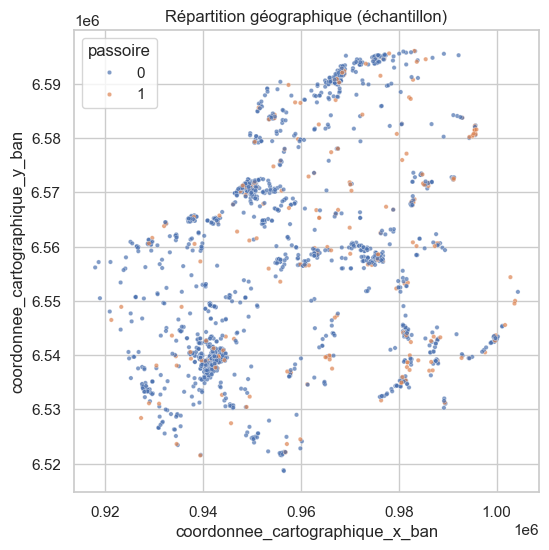

In [57]:
lat_col = 'coordonnee_cartographique_y_ban'
lon_col = 'coordonnee_cartographique_x_ban'
if lat_col in df.columns and lon_col in df.columns:
    sub = df[[lon_col, lat_col, 'passoire']].dropna().sample(min(2000, len(df.dropna(subset=[lon_col, lat_col]))))
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=sub, x=lon_col, y=lat_col, hue='passoire', s=10, alpha=0.7)
    plt.title('Répartition géographique (échantillon)')
    plt.show()
else:
    print('Colonnes de coordonnées non trouvées ou manquantes dans le dataset.')


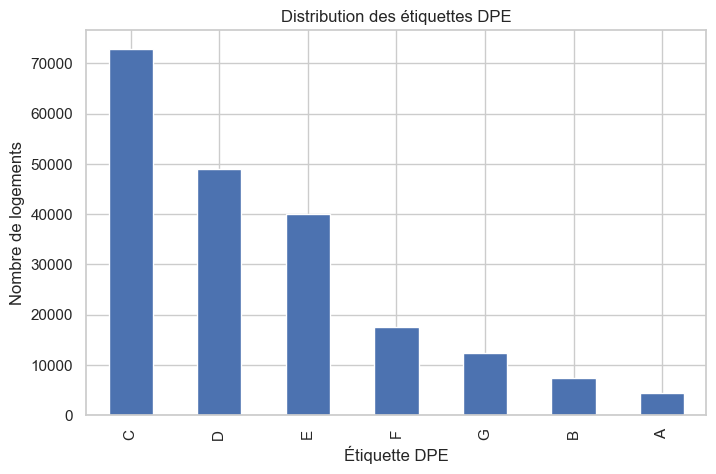

In [58]:
df['etiquette_dpe'].value_counts().plot(kind='bar', figsize=(8,5), title='Distribution des étiquettes DPE')
plt.xlabel('Étiquette DPE') 
plt.ylabel('Nombre de logements')
plt.show()

## Partie 1 : Préparation des données et identification des variables cibles

### 1.1 Identification de la variable de consommation électrique

Nous allons d'abord identifier les colonnes liées à la consommation électrique pour notre modèle de régression.

In [59]:
# Recherche des colonnes liées à la consommation
conso_cols = [col for col in df.columns if 'conso' in col.lower()]
print('Colonnes de consommation disponibles:')
for col in conso_cols:
    print(f"  - {col}")
    
# Afficher statistiques pour les colonnes de consommation numériques
print('\n--- Statistiques des colonnes de consommation ---')
for col in conso_cols:
    if df[col].dtype in ['float64', 'int64']:
        print(f"\n{col}:")
        print(f"  Valeurs manquantes: {df[col].isna().sum()} ({df[col].isna().mean()*100:.2f}%)")
        print(f"  Min: {df[col].min():.2f}, Max: {df[col].max():.2f}, Moyenne: {df[col].mean():.2f}")

Colonnes de consommation disponibles:
  - conso_chauffage_installation_chauffage_n1
  - conso_auxiliaires_ep
  - conso_auxiliaires_ef
  - conso_5_usages_par_m2_ep
  - conso_ecs_ef_energie_n1
  - conso_5_usages_par_m2_ef
  - conso_chauffage_ef_energie_n1
  - conso_chauffage_generateur_n1_installation_n1
  - conso_5_usages_ef
  - conso_5_usages_ef_energie_n1
  - conso_5_usages_ep
  - conso_chauffage_ef
  - conso_ecs_ep
  - conso_ecs_ef
  - conso_ef_installation_ecs_n1
  - conso_refroidissement_ef
  - conso_eclairage_ef
  - conso_ef_generateur_n1_ecs_n1
  - conso_chauffage_ep
  - conso_eclairage_ep
  - conso_refroidissement_ep
  - conso_ecs_ef_energie_n3
  - conso_ecs_ef_energie_n2
  - conso_chauffage_ef_energie_n2
  - conso_chauffage_ef_energie_n3
  - conso_5_usages_ef_energie_n3
  - conso_5_usages_ef_energie_n2
  - conso_chauffage_generateur_n2_installation_n1
  - conso_chauffage_generateur_n1_installation_n2
  - conso_chauffage_installation_chauffage_n2
  - conso_refroidissement_annuel

### 1.2 Identification des variables explicatives pertinentes

Nous allons identifier les variables potentiellement importantes pour nos modèles :
- Variables géographiques (zone climatique, altitude, coordonnées)
- Caractéristiques du logement (surface, année de construction, isolation, etc.)
- Caractéristiques énergétiques (type de chauffage, isolation, etc.)

In [60]:
# Recherche de colonnes clés pour l'analyse
keywords = {
    'géographique': ['altitude', 'zone', 'climat', 'region', 'coordonnee'],
    'logement': ['surface', 'annee', 'construction', 'niveau', 'hauteur'],
    'isolation': ['isolation', 'menuiserie', 'mur', 'toiture', 'plancher', 'enveloppe'],
    'chauffage': ['chauffage', 'generateur', 'energie', 'emetteur'],
    'ecs': ['ecs', 'eau_chaude'],
    'dpe': ['dpe', 'etiquette', 'classe', 'emission', 'ges']
}

print("=== Variables disponibles par catégorie ===\n")
variables_interessantes = []
for categorie, mots_cles in keywords.items():
    cols = []
    for mot in mots_cles:
        cols.extend([c for c in df.columns if mot.lower() in c.lower() and c not in cols])
    print(f"\n{categorie.upper()} ({len(cols)} colonnes):")
    for col in cols[:15]:  # Limite à 15 pour lisibilité
        variables_interessantes.append(col)
        taux_manquant = df[col].isna().mean() * 100
        print(f"  - {col} (manquants: {taux_manquant:.1f}%)")

=== Variables disponibles par catégorie ===


GÉOGRAPHIQUE (8 colonnes):
  - classe_altitude (manquants: 10.9%)
  - altitude_moyenne (manquants: 0.0%)
  - zone_climatique (manquants: 10.9%)
  - type_energie_climatisation (manquants: 98.4%)
  - surface_climatisee (manquants: 98.3%)
  - code_region_ban (manquants: 0.0%)
  - coordonnee_cartographique_x_ban (manquants: 0.0%)
  - coordonnee_cartographique_y_ban (manquants: 0.0%)

LOGEMENT (14 colonnes):
  - surface_chauffee_installation_chauffage_n1 (manquants: 18.8%)
  - surface_habitable_desservie_par_installation_ecs_n1 (manquants: 18.9%)
  - surface_habitable_logement (manquants: 2.8%)
  - surface_chauffee_installation_chauffage_n2 (manquants: 85.4%)
  - surface_climatisee (manquants: 98.3%)
  - surface_habitable_immeuble (manquants: 36.1%)
  - surface_ventilee (manquants: 96.5%)
  - surface_totale_capteurs_pv (manquants: 99.3%)
  - surface_tertiaire_immeuble (manquants: 99.9%)
  - annee_construction (manquants: 42.6%)
  - periode_const

## Partie 2 : Prétraitement et sélection des features

### 2.1 Préparation du dataset pour la modélisation

Nous allons :
1. Séparer les variables numériques et catégorielles
2. Gérer les valeurs manquantes
3. Créer un ensemble de features potentielles

In [61]:
# Imports supplémentaires pour la modélisation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, mutual_info_regression, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [62]:
# Définir la cible pour la régression (consommation électrique)
# Choisissons une variable de consommation appropriée
target_regression = 'conso_5_usages_ep'  # Consommation 5 usages en énergie primaire

# Vérifier la disponibilité de la cible
print(f"Target régression : {target_regression}")
print(f"Valeurs manquantes : {df[target_regression].isna().sum()} ({df[target_regression].isna().mean()*100:.2f}%)")
print(f"Statistiques :\n{df[target_regression].describe()}")

# Créer un dataframe de travail sans les lignes où la cible est manquante
df_work = df[df[target_regression].notna() & df['passoire'].notna()].copy()
print(f"\nDataset de travail : {df_work.shape}")

Target régression : conso_5_usages_ep
Valeurs manquantes : 5 (0.00%)
Statistiques :
count    2.037920e+05
mean     2.164666e+04
std      5.589591e+04
min      3.141000e+02
25%      6.977575e+03
50%      1.131610e+04
75%      1.956080e+04
max      5.957086e+06
Name: conso_5_usages_ep, dtype: float64

Dataset de travail : (203792, 237)

Dataset de travail : (203792, 237)


In [63]:
# Sélectionner les colonnes potentiellement utiles
# On exclut les colonnes liées à la cible (consommation, émission, DPE, coûts)
# ET les calculs intermédiaires du DPE (besoins, déperditions) qui sont des fuites
colonnes_a_exclure = ['conso', 'emission', 'cout', 'etiquette_dpe', 'etiquette_ges',
                      'date_', 'passoire', '_rand', '_geopoint',
                      'besoin_', 'deperdition',  # Calculs intermédiaires DPE
                      'methode_application_dpe', 'modele_dpe',  # Variables administratives/techniques DPE
                      'surface_chauffee_installation_chauffage_n1',  # VIF > 10 (multicolinéarité)
                      'surface_habitable_desservie_par_installation_ecs_n1']  # VIF > 10 (multicolinéarité)

# Créer liste des features candidates
features_candidates = []
for col in df_work.columns:
    # Exclure les colonnes liées aux résultats
    if not any(exclu in col.lower() for exclu in colonnes_a_exclure):
        features_candidates.append(col)

print(f"Nombre de features candidates : {len(features_candidates)}")
print(f"\nPremières features : {features_candidates[:20]}")

Nombre de features candidates : 141

Premières features : ['configuration_installation_chauffage_n1', 'type_generateur_n1_ecs_n1', 'numero_voie_ban', 'score_ban', 'statut_geocodage', 'ventilation_posterieure_2012', 'description_installation_chauffage_n1', 'presence_brasseur_air', 'qualite_isolation_menuiseries', 'isolation_toiture', 'qualite_isolation_enveloppe', 'type_energie_n1', 'code_postal_ban', 'code_insee_ban', 'code_region_ban', 'volume_stockage_generateur_n1_ecs_n1', 'version_dpe', 'coordonnee_cartographique_x_ban', 'type_generateur_chauffage_principal', 'type_energie_principale_ecs']


In [64]:
# Séparer variables numériques et catégorielles
numeric_features = []
categorical_features = []

for col in features_candidates:
    if df_work[col].dtype in ['float64', 'int64']:
        # Vérifier si pas trop de valeurs manquantes (< 50%)
        if df_work[col].isna().mean() < 0.5:
            numeric_features.append(col)
    elif df_work[col].dtype == 'object':
        # Pour les catégorielles, garder celles avec peu de modalités et peu de manquants
        n_unique = df_work[col].nunique()
        if n_unique < 50 and df_work[col].isna().mean() < 0.5:
            categorical_features.append(col)

print(f"Variables numériques sélectionnées : {len(numeric_features)}")
print(f"Variables catégorielles sélectionnées : {len(categorical_features)}")
print(f"\nExemples de variables numériques : {numeric_features[:10]}")
print(f"\nExemples de variables catégorielles : {categorical_features[:10]}")

Variables numériques sélectionnées : 35
Variables catégorielles sélectionnées : 29

Exemples de variables numériques : ['score_ban', 'ventilation_posterieure_2012', 'presence_brasseur_air', 'isolation_toiture', 'code_postal_ban', 'code_insee_ban', 'code_region_ban', 'volume_stockage_generateur_n1_ecs_n1', 'version_dpe', 'coordonnee_cartographique_x_ban']

Exemples de variables catégorielles : ['configuration_installation_chauffage_n1', 'statut_geocodage', 'qualite_isolation_menuiseries', 'qualite_isolation_enveloppe', 'type_energie_n1', 'type_energie_principale_ecs', 'type_installation_chauffage', 'type_installation_ecs_n1', 'type_emetteur_installation_chauffage_n1', 'configuration_installation_ecs_n1']


### Analyse approfondie de la sélection des variables

Avant de procéder à la sélection automatique, nous allons analyser en détail la pertinence des variables selon les meilleures pratiques :

1. **Vérification des variables clés recommandées** (structure, isolation, chauffage, ECS, climat)
2. **Analyse des corrélations** avec la cible (régression)
3. **Tests statistiques Chi-2** pour les variables catégorielles (classification)
4. **Détection de la multicolinéarité** (VIF)

In [65]:
# ========================================
# 1. VÉRIFICATION DES VARIABLES CLÉS RECOMMANDÉES
# ========================================

variables_cles = {
    'structure': ['surface_habitable', 'nombre_niveau', 'hauteur_sous_plafond', 
                  'periode_construction', 'annee_construction', 'volume_stockage', 'type_batiment',
                  'numero_etage', 'logement_traversant'],
    'isolation': ['qualite_isolation_enveloppe', 'qualite_isolation_murs', 
                  'qualite_isolation_menuiseries', 'qualite_isolation_plancher_bas',
                  'qualite_isolation_plancher_haut', 'ubat', 'deperdition'],
    'chauffage': ['type_generateur_chauffage', 'type_energie_principale_chauffage',
                  'type_emetteur', 'besoin_chauffage', 'type_installation_chauffage'],
    'ecs': ['type_generateur_n1_ecs', 'type_energie_principale_ecs', 'besoin_ecs'],
    'climat': ['zone_climatique', 'classe_altitude', 'altitude_moyenne', 'altitude'],
    'ventilation': ['type_ventilation', 'classe_inertie', 'indicateur_confort']
}

print("="*80)
print("VARIABLES CLÉS RECOMMANDÉES - PRÉSENCE ET QUALITÉ")
print("="*80)

variables_trouvees = {}

for categorie, vars_list in variables_cles.items():
    print(f"\n{'─'*80}")
    print(f"{categorie.upper()}")
    print(f"{'─'*80}")
    
    variables_trouvees[categorie] = []
    
    for var_pattern in vars_list:
        matching = [c for c in df_work.columns if var_pattern.lower() in c.lower() 
                   and not any(exclu in c.lower() for exclu in ['conso', 'emission', 'cout', 'etiquette'])]
        
        if matching:
            for var in matching:
                missing_pct = df_work[var].isna().mean() * 100
                dtype = df_work[var].dtype
                n_unique = df_work[var].nunique() if dtype == 'object' else '-'
                
                status = "✓" if missing_pct < 50 else "⚠"
                print(f"  {status} {var:50s} | Manquants: {missing_pct:5.1f}% | Type: {str(dtype):10s} | Modalités: {n_unique}")
                
                if missing_pct < 50:  # Garder seulement si < 50% de manquants
                    variables_trouvees[categorie].append(var)
        else:
            print(f"  ✗ Pattern '{var_pattern}' non trouvé")

print(f"\n{'='*80}")
print(f"RÉSUMÉ: {sum(len(v) for v in variables_trouvees.values())} variables clés disponibles")
print(f"{'='*80}")

VARIABLES CLÉS RECOMMANDÉES - PRÉSENCE ET QUALITÉ

────────────────────────────────────────────────────────────────────────────────
STRUCTURE
────────────────────────────────────────────────────────────────────────────────
  ✓ surface_habitable_desservie_par_installation_ecs_n1 | Manquants:  18.9% | Type: float64    | Modalités: -
  ✓ surface_habitable_logement                         | Manquants:   2.8% | Type: float64    | Modalités: -
  ✓ surface_habitable_immeuble                         | Manquants:  36.1% | Type: float64    | Modalités: -
  ✓ nombre_niveau_logement                             | Manquants:   6.5% | Type: float64    | Modalités: -
  ⚠ nombre_niveau_immeuble                             | Manquants:  56.7% | Type: float64    | Modalités: -
  ✓ hauteur_sous_plafond                               | Manquants:   0.0% | Type: float64    | Modalités: -
  ✓ periode_construction                               | Manquants:  16.2% | Type: object     | Modalités: 10
  ✓ annee_co


TOP CORRÉLATIONS AVEC LA CONSOMMATION ÉLECTRIQUE

Top 30 corrélations (valeur absolue) :
────────────────────────────────────────────────────────────────────────────────
 1. surface_habitable_logement                         | r = +0.7125 (↑ Positive)
 2. surface_ventilee                                   | r = +0.5977 (↑ Positive)
 3. volume_stockage_generateur_n2_ecs_n1               | r = +0.4043 (↑ Positive)
 4. logement_traversant                                | r = +0.2789 (↑ Positive)
 5. apport_interne_saison_chauffe                      | r = +0.2728 (↑ Positive)
 6. facteur_couverture_solaire_installation_chauffage_n2 | r = -0.2535 (↓ Négative)
 7. surface_climatisee                                 | r = +0.2378 (↑ Positive)
 8. apport_solaire_saison_chauffe                      | r = +0.2197 (↑ Positive)
 9. isolation_toiture                                  | r = +0.2171 (↑ Positive)
10. facteur_couverture_solaire_saisi_installation_chauffage_n1 | r = -0.1871 (↓ Négative)

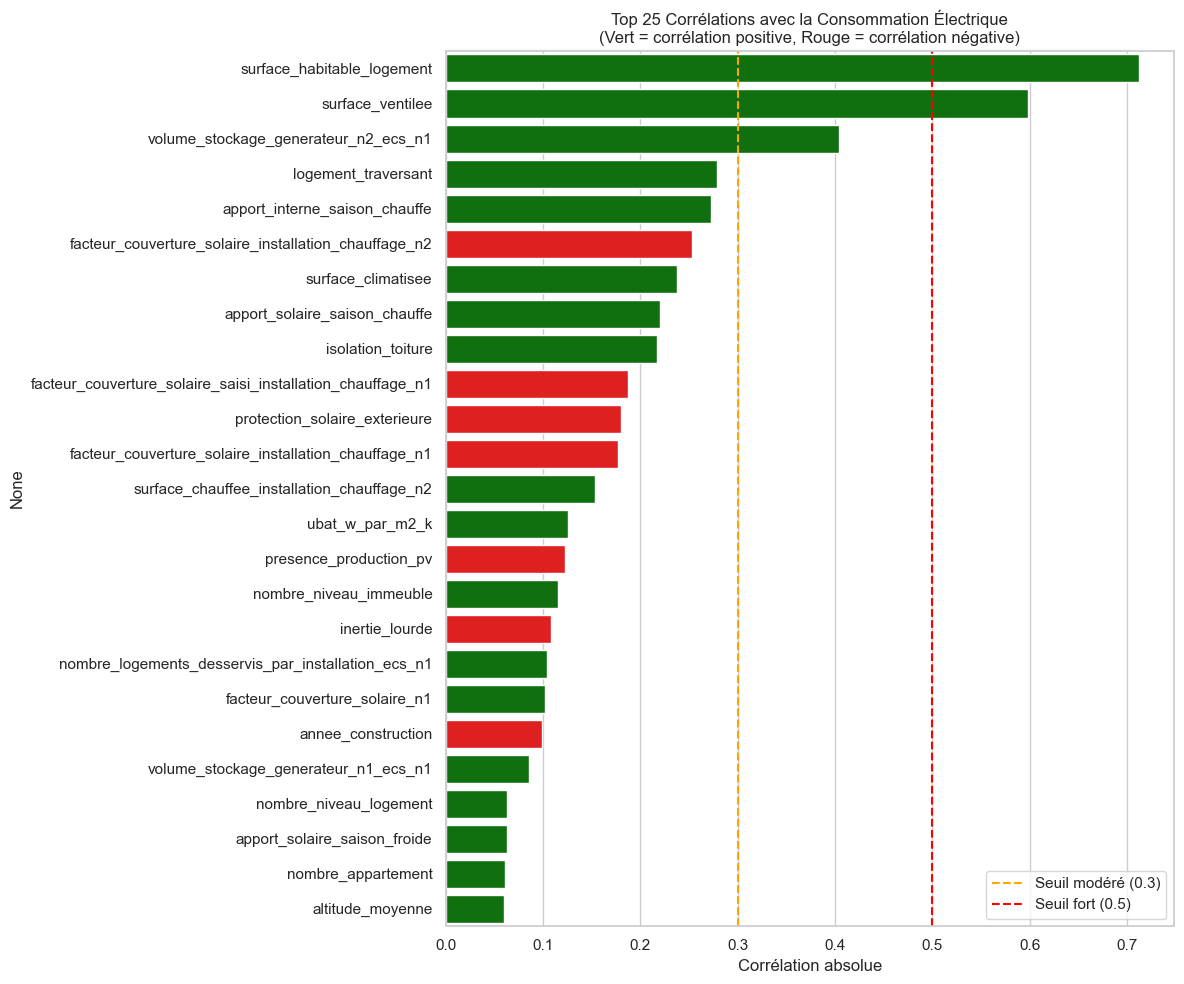


✓ Variables avec corrélation > 0.3: 3
✓ Variables avec corrélation > 0.5: 2


In [66]:
# ========================================
# 2. CORRÉLATIONS AVEC LA CIBLE (RÉGRESSION)
# ========================================

print("\n" + "="*80)
print("TOP CORRÉLATIONS AVEC LA CONSOMMATION ÉLECTRIQUE")
print("="*80)

# Identifier les colonnes numériques (excluant les fuites de données)
numeric_cols_for_corr = [c for c in df_work.select_dtypes(include=[np.number]).columns 
                         if not any(exclu in c.lower() for exclu in ['conso', 'emission', 'cout', 'etiquette_dpe', 'etiquette_ges',
                                                                       'passoire', 'besoin_', 'deperdition',
                                                                       'methode_application_dpe', 'modele_dpe',
                                                                       'surface_chauffee_installation_chauffage_n1',
                                                                       'surface_habitable_desservie_par_installation_ecs_n1'])]  # Exclusion calculs DPE + variables admin + VIF > 10

# Calculer les corrélations avec la cible
correlations = df_work[numeric_cols_for_corr].corrwith(df_work[target_regression]).abs().sort_values(ascending=False)

# Afficher les top 30
print("\nTop 30 corrélations (valeur absolue) :")
print("─"*80)
for i, (var, corr) in enumerate(correlations.head(30).items(), 1):
    corr_signed = df_work[var].corr(df_work[target_regression])
    direction = "↑ Positive" if corr_signed > 0 else "↓ Négative"
    print(f"{i:2d}. {var:50s} | r = {corr_signed:+.4f} ({direction})")

# Visualisation
plt.figure(figsize=(12, 10))
top_corr = correlations.head(25)
colors = ['green' if df_work[var].corr(df_work[target_regression]) > 0 else 'red' 
          for var in top_corr.index]
sns.barplot(x=top_corr.values, y=top_corr.index, palette=colors)
plt.title('Top 25 Corrélations avec la Consommation Électrique\n(Vert = corrélation positive, Rouge = corrélation négative)')
plt.xlabel('Corrélation absolue')
plt.axvline(x=0.3, color='orange', linestyle='--', label='Seuil modéré (0.3)')
plt.axvline(x=0.5, color='red', linestyle='--', label='Seuil fort (0.5)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n✓ Variables avec corrélation > 0.3: {(correlations > 0.3).sum()}")
print(f"✓ Variables avec corrélation > 0.5: {(correlations > 0.5).sum()}")


TEST CHI-2 POUR LA PRÉDICTION DES PASSOIRES ÉNERGÉTIQUES

Analyse de 29 variables catégorielles...

Top 20 variables catégorielles les plus discriminantes :
────────────────────────────────────────────────────────────────────────────────
qualite_isolation_enveloppe                        | Chi2 =   20033.54 | p-value = 0.00e+00 ***
configuration_installation_ecs_n1                  | Chi2 =   11331.49 | p-value = 0.00e+00 ***
zone_climatique                                    | Chi2 =   10567.75 | p-value = 0.00e+00 ***
periode_construction                               | Chi2 =   10349.45 | p-value = 0.00e+00 ***
type_energie_generateur_n1_installation_n1         | Chi2 =   10299.21 | p-value = 0.00e+00 ***
type_installation_solaire_n1                       | Chi2 =    7886.34 | p-value = 0.00e+00 ***
qualite_isolation_murs                             | Chi2 =    6695.86 | p-value = 0.00e+00 ***
type_energie_principale_ecs                        | Chi2 =    6524.15 | p-value = 0.00e+

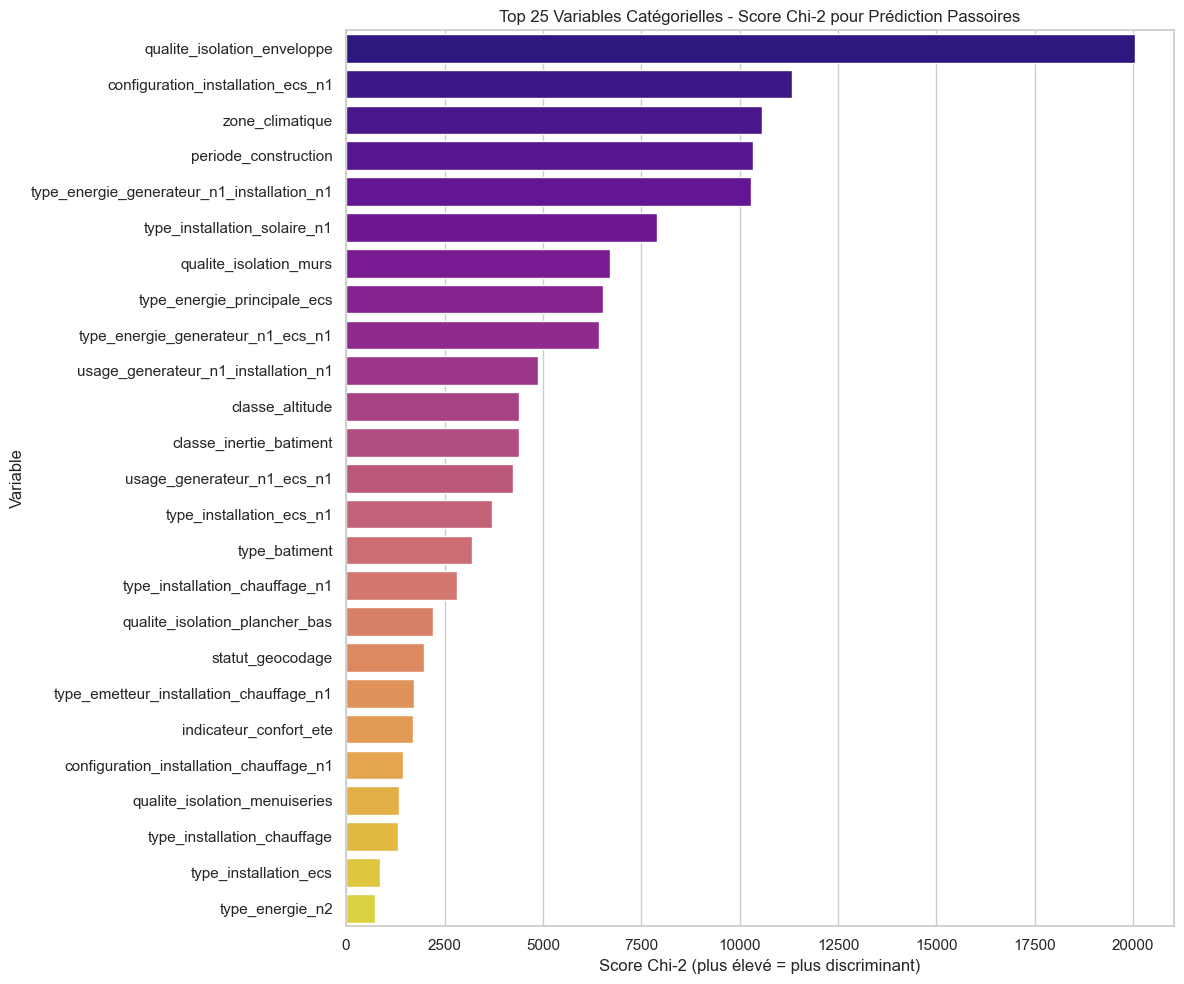


✓ Variables significatives (p < 0.05): 27
✓ Variables très significatives (p < 0.001): 27


In [67]:
# ========================================
# 3. TEST CHI-2 POUR VARIABLES CATÉGORIELLES (CLASSIFICATION)
# ========================================

from sklearn.feature_selection import chi2

print("\n" + "="*80)
print("TEST CHI-2 POUR LA PRÉDICTION DES PASSOIRES ÉNERGÉTIQUES")
print("="*80)

# Encoder les variables catégorielles pour le test Chi-2
categorical_for_chi2 = [col for col in categorical_features if col in df_work.columns]

if len(categorical_for_chi2) > 0:
    print(f"\nAnalyse de {len(categorical_for_chi2)} variables catégorielles...\n")
    
    # Encoder les catégorielles (factorize convertit en entiers)
    categorical_encoded = pd.DataFrame()
    for col in categorical_for_chi2:
        categorical_encoded[col] = pd.factorize(df_work[col].fillna('MISSING'))[0]
    
    # Test Chi-2
    chi2_scores, p_values = chi2(categorical_encoded, df_work['passoire'])
    
    # Créer un DataFrame des résultats
    chi2_df = pd.DataFrame({
        'Variable': categorical_for_chi2,
        'Chi2_Score': chi2_scores,
        'P_Value': p_values
    }).sort_values('Chi2_Score', ascending=False)
    
    # Afficher les top 20
    print("Top 20 variables catégorielles les plus discriminantes :")
    print("─"*80)
    for i, row in chi2_df.head(20).iterrows():
        significance = "***" if row['P_Value'] < 0.001 else "**" if row['P_Value'] < 0.01 else "*" if row['P_Value'] < 0.05 else ""
        print(f"{row['Variable']:50s} | Chi2 = {row['Chi2_Score']:10.2f} | p-value = {row['P_Value']:.2e} {significance}")
    
    print("\n*** p < 0.001 (très significatif), ** p < 0.01, * p < 0.05")
    
    # Visualisation
    plt.figure(figsize=(12, 10))
    top_chi2 = chi2_df.head(25)
    sns.barplot(data=top_chi2, y='Variable', x='Chi2_Score', palette='plasma')
    plt.title('Top 25 Variables Catégorielles - Score Chi-2 pour Prédiction Passoires')
    plt.xlabel('Score Chi-2 (plus élevé = plus discriminant)')
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Variables significatives (p < 0.05): {(chi2_df['P_Value'] < 0.05).sum()}")
    print(f"✓ Variables très significatives (p < 0.001): {(chi2_df['P_Value'] < 0.001).sum()}")
else:
    print("⚠ Aucune variable catégorielle disponible pour le test Chi-2")


DÉTECTION DE LA MULTICOLINÉARITÉ (VIF - Variance Inflation Factor)

Critères d'interprétation :
  • VIF < 5   : Pas de multicolinéarité
  • VIF 5-10  : Multicolinéarité modérée
  • VIF > 10  : Multicolinéarité forte (variable redondante)

Calcul sur un échantillon de 5000 observations...
Analyse de 33 variables numériques...

Analyse de 33 variables numériques...

Variables avec FORTE multicolinéarité (VIF > 10) :
────────────────────────────────────────────────────────────────────────────────
✓ Aucune variable avec VIF > 10

────────────────────────────────────────────────────────────────────────────────
Variables avec multicolinéarité MODÉRÉE (5 < VIF < 10) :
────────────────────────────────────────────────────────────────────────────────
  densite                                            | VIF =     6.89
  apport_interne_saison_chauffe                      | VIF =     6.53
  population                                         | VIF =     6.30
  apport_solaire_saison_chauffe       

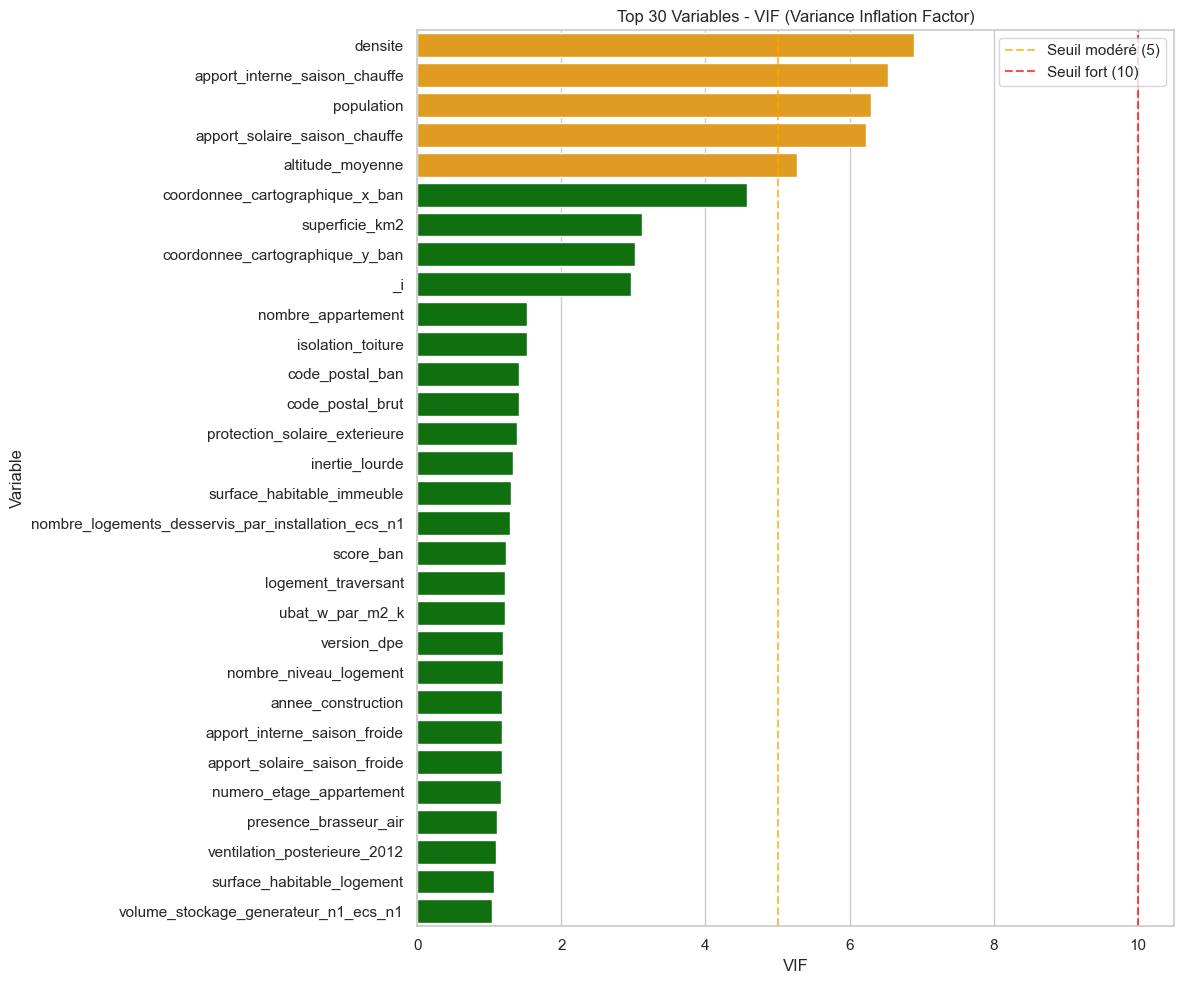


RECOMMANDATIONS
✓ Pas de problème majeur de multicolinéarité


In [68]:
# ========================================
# 4. DÉTECTION DE LA MULTICOLINÉARITÉ (VIF)
# ========================================

from statsmodels.stats.outliers_influence import variance_inflation_factor

print("\n" + "="*80)
print("DÉTECTION DE LA MULTICOLINÉARITÉ (VIF - Variance Inflation Factor)")
print("="*80)

print("\nCritères d'interprétation :")
print("  • VIF < 5   : Pas de multicolinéarité")
print("  • VIF 5-10  : Multicolinéarité modérée")
print("  • VIF > 10  : Multicolinéarité forte (variable redondante)\n")

# Prendre un échantillon pour accélérer le calcul
sample_size = min(5000, len(df_work))
print(f"Calcul sur un échantillon de {sample_size} observations...")

# Sélectionner les variables numériques pertinentes
numeric_for_vif = [col for col in numeric_features if col in df_work.columns][:50]  # Limiter à 50 pour la rapidité

if len(numeric_for_vif) > 2:
    # Échantillonner et imputer
    X_vif = df_work[numeric_for_vif].sample(n=sample_size, random_state=42)
    X_vif_filled = X_vif.fillna(X_vif.median())
    
    # Retirer les colonnes avec variance nulle
    X_vif_filled = X_vif_filled.loc[:, X_vif_filled.std() > 0]
    
    print(f"Analyse de {len(X_vif_filled.columns)} variables numériques...\n")
    
    # Calculer les VIF
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_vif_filled.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif_filled.values, i) 
                       for i in range(len(X_vif_filled.columns))]
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    # Afficher les variables avec forte multicolinéarité
    print("Variables avec FORTE multicolinéarité (VIF > 10) :")
    print("─"*80)
    high_vif = vif_data[vif_data['VIF'] > 10]
    if len(high_vif) > 0:
        for i, row in high_vif.iterrows():
            print(f"⚠ {row['Variable']:50s} | VIF = {row['VIF']:8.2f}")
        print(f"\n⚠ {len(high_vif)} variables avec forte multicolinéarité détectées")
        print("→ Considérer la suppression de ces variables ou utiliser PCA/régularisation")
    else:
        print("✓ Aucune variable avec VIF > 10")
    
    # Afficher les variables avec multicolinéarité modérée
    print("\n" + "─"*80)
    print("Variables avec multicolinéarité MODÉRÉE (5 < VIF < 10) :")
    print("─"*80)
    moderate_vif = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]
    if len(moderate_vif) > 0:
        for i, row in moderate_vif.head(15).iterrows():
            print(f"  {row['Variable']:50s} | VIF = {row['VIF']:8.2f}")
        print(f"\n{len(moderate_vif)} variables avec multicolinéarité modérée")
    else:
        print("✓ Aucune variable avec VIF entre 5 et 10")
    
    # Visualisation
    plt.figure(figsize=(12, 10))
    top_vif = vif_data.head(30)
    colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' for x in top_vif['VIF']]
    sns.barplot(data=top_vif, y='Variable', x='VIF', palette=colors)
    plt.axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='Seuil modéré (5)')
    plt.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='Seuil fort (10)')
    plt.title('Top 30 Variables - VIF (Variance Inflation Factor)')
    plt.xlabel('VIF')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Recommandations
    print("\n" + "="*80)
    print("RECOMMANDATIONS")
    print("="*80)
    if len(high_vif) > 0:
        print(f"⚠ {len(high_vif)} variables redondantes détectées (VIF > 10)")
        print("  → Options: supprimer, utiliser PCA, ou régularisation (Lasso, Ridge)")
    else:
        print("✓ Pas de problème majeur de multicolinéarité")
else:
    print("⚠ Pas assez de variables numériques pour le calcul du VIF")


ANALYSE SPÉCIFIQUE SAVOIE (74) - IMPACT ALTITUDE ET CLIMAT

1. Variables d'ALTITUDE disponibles :
────────────────────────────────────────────────────────────────────────────────
  altitude_moyenne                         | Corrélation: +0.0599 | Manquants: 0.0%
    → Min: 335m, Max: 2445m, Moyenne: 742m

2. Variables de ZONE CLIMATIQUE disponibles :
────────────────────────────────────────────────────────────────────────────────
  zone_climatique                          | Modalités:   9 | Manquants: 10.9%
  type_energie_climatisation               | Modalités:   2 | Manquants: 98.4%
  surface_climatisee                       | Modalités: 1345 | Manquants: 98.3%

✓ Colonne d'altitude utilisée: altitude_moyenne
✓ 203792 observations valides pour l'analyse graphique
  surface_climatisee                       | Modalités: 1345 | Manquants: 98.3%

✓ Colonne d'altitude utilisée: altitude_moyenne
✓ 203792 observations valides pour l'analyse graphique


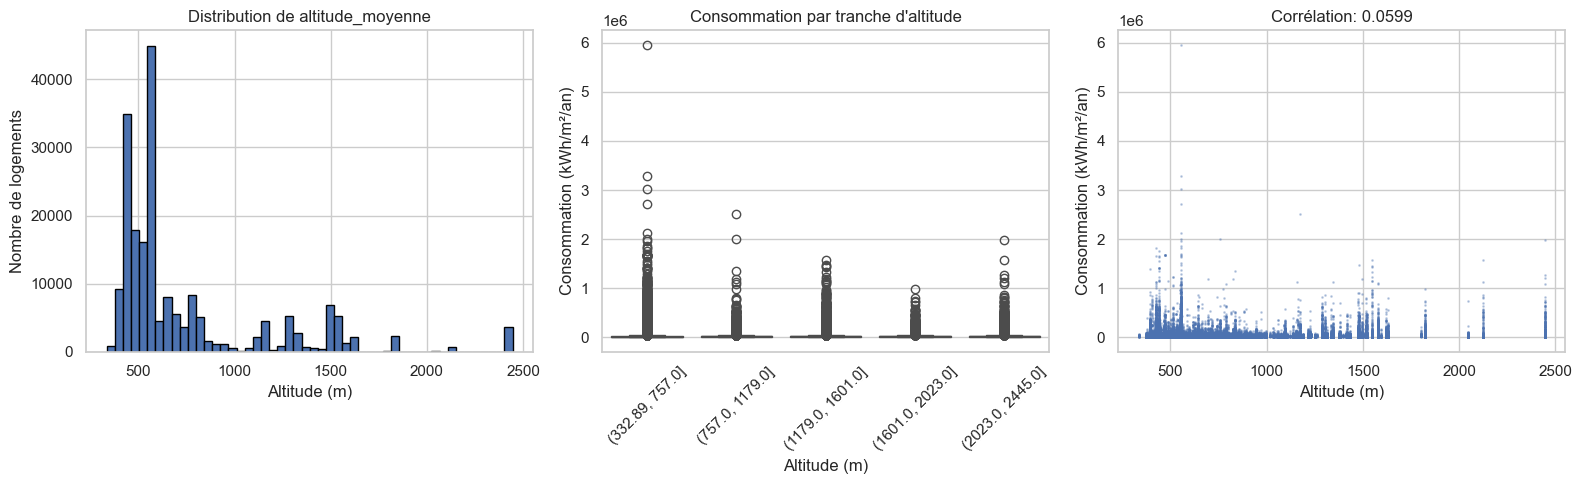


3. Consommation moyenne par TRANCHE D'ALTITUDE :
────────────────────────────────────────────────────────────────────────────────
                   Conso_Moyenne  Conso_Médiane  Nb_Logements  Taux_Passoires
altitude_tranches                                                            
< 400m                  19140.45        9450.50          5280            0.07
400-600m                19757.03       10554.40        119734            0.11
600-800m                20241.17       11085.80         28814            0.13
800-1000m               24212.95       15078.30          9462            0.18
> 1000m                 27959.99       13591.15         40502            0.26

→ En Haute-Savoie, l'altitude est un facteur MAJEUR de consommation énergétique
→ Plus l'altitude augmente, plus les besoins en chauffage sont importants


In [69]:
# ========================================
# 5. ANALYSE SPÉCIFIQUE : ALTITUDE ET ZONE CLIMATIQUE
# ========================================

print("\n" + "="*80)
print("ANALYSE SPÉCIFIQUE SAVOIE (74) - IMPACT ALTITUDE ET CLIMAT")
print("="*80)

# Rechercher les colonnes liées à l'altitude et au climat
altitude_cols = [col for col in df_work.columns if 'altitude' in col.lower()]
climat_cols = [col for col in df_work.columns if 'climat' in col.lower() or 'zone' in col.lower()]

print("\n1. Variables d'ALTITUDE disponibles :")
print("─"*80)
for col in altitude_cols:
    if col in numeric_cols_for_corr:
        corr_conso = df_work[col].corr(df_work[target_regression])
        missing = df_work[col].isna().mean() * 100
        print(f"  {col:40s} | Corrélation: {corr_conso:+.4f} | Manquants: {missing:.1f}%")
        
        # Statistiques descriptives
        print(f"    → Min: {df_work[col].min():.0f}m, Max: {df_work[col].max():.0f}m, Moyenne: {df_work[col].mean():.0f}m")

print("\n2. Variables de ZONE CLIMATIQUE disponibles :")
print("─"*80)
for col in climat_cols:
    missing = df_work[col].isna().mean() * 100
    n_unique = df_work[col].nunique()
    print(f"  {col:40s} | Modalités: {n_unique:3d} | Manquants: {missing:.1f}%")

# Analyse de la distribution de l'altitude si disponible
if altitude_cols:
    # Identifier la colonne numérique d'altitude (pas la classe catégorielle)
    numeric_altitude_col = None
    for col in altitude_cols:
        if df_work[col].dtype in ['float64', 'int64']:
            numeric_altitude_col = col
            break
    
    if numeric_altitude_col is None:
        print("⚠️ Aucune colonne d'altitude numérique trouvée")
        print(f"Colonnes disponibles: {altitude_cols}")
    else:
        main_altitude_col = numeric_altitude_col
        print(f"\n✓ Colonne d'altitude utilisée: {main_altitude_col}")
        
        # S'assurer que l'altitude est numérique
        altitude_data = pd.to_numeric(df_work[main_altitude_col], errors='coerce')
        
        # Créer un DataFrame propre pour l'analyse
        df_altitude_clean = pd.DataFrame({
            'altitude': altitude_data,
            'conso': df_work[target_regression]
        }).dropna()
        
        if len(df_altitude_clean) > 0:
            print(f"✓ {len(df_altitude_clean)} observations valides pour l'analyse graphique")
            
            # Distribution de l'altitude
            fig, axes = plt.subplots(1, 3, figsize=(16, 5))
            
            # Subplot 1: Histogramme
            axes[0].hist(df_altitude_clean['altitude'], bins=50, edgecolor='black')
            axes[0].set_title(f'Distribution de {main_altitude_col}')
            axes[0].set_xlabel('Altitude (m)')
            axes[0].set_ylabel('Nombre de logements')
            
            # Subplot 2: Boxplot par tranche d'altitude
            try:
                df_altitude_clean['altitude_bin'] = pd.cut(df_altitude_clean['altitude'], bins=5)
                sns.boxplot(data=df_altitude_clean, x='altitude_bin', y='conso', ax=axes[1])
                axes[1].set_title('Consommation par tranche d\'altitude')
                axes[1].set_xlabel('Altitude (m)')
                axes[1].set_ylabel('Consommation (kWh/m²/an)')
                axes[1].tick_params(axis='x', rotation=45)
            except Exception as e:
                axes[1].text(0.5, 0.5, f'Erreur boxplot:\n{str(e)}', 
                            ha='center', va='center', transform=axes[1].transAxes)
                axes[1].set_title('Consommation par tranche d\'altitude (erreur)')
            
            # Subplot 3: Scatter plot
            axes[2].scatter(df_altitude_clean['altitude'], df_altitude_clean['conso'], alpha=0.3, s=1)
            axes[2].set_xlabel('Altitude (m)')
            axes[2].set_ylabel('Consommation (kWh/m²/an)')
            correlation = df_altitude_clean['altitude'].corr(df_altitude_clean['conso'])
            axes[2].set_title(f'Corrélation: {correlation:.4f}')
            
            plt.tight_layout()
            plt.show()
            
            # Analyse par tranches d'altitude
            print("\n3. Consommation moyenne par TRANCHE D'ALTITUDE :")
            print("─"*80)
            
            # Créer les tranches avec les données propres
            df_altitude_clean['altitude_tranches'] = pd.cut(
                df_altitude_clean['altitude'], 
                bins=[0, 400, 600, 800, 1000, 3000], 
                labels=['< 400m', '400-600m', '600-800m', '800-1000m', '> 1000m']
            )
            
            # Joindre avec la colonne passoire
            df_for_groupby = df_altitude_clean.copy()
            df_for_groupby['passoire'] = df_work.loc[df_altitude_clean.index, 'passoire']
            
            altitude_analysis = df_for_groupby.groupby('altitude_tranches', observed=True).agg({
                'conso': ['mean', 'median', 'count'],
                'passoire': 'mean'
            }).round(2)
            
            altitude_analysis.columns = ['Conso_Moyenne', 'Conso_Médiane', 'Nb_Logements', 'Taux_Passoires']
            print(altitude_analysis)
            
            print("\n→ En Haute-Savoie, l'altitude est un facteur MAJEUR de consommation énergétique")
            print("→ Plus l'altitude augmente, plus les besoins en chauffage sont importants")
        else:
            print("⚠️ Aucune donnée valide pour créer les graphiques d'altitude")

In [70]:
# ========================================
# 6. SÉLECTION INTELLIGENTE DES FEATURES BASÉE SUR LES ANALYSES
# ========================================

print("\n" + "="*80)
print("SÉLECTION INTELLIGENTE DES FEATURES (Basée sur analyses statistiques)")
print("="*80)

# ─────────────────────────────────────────
# ÉTAPE 1 : Identifier les features à EXCLURE (VIF > 10)
# ─────────────────────────────────────────
features_to_exclude_vif = []
if 'vif_data' in locals() and len(vif_data) > 0:
    high_vif_vars = vif_data[vif_data['VIF'] > 10]['Variable'].tolist()
    features_to_exclude_vif.extend(high_vif_vars)
    print(f"\n⚠ Variables exclues (VIF > 10): {len(features_to_exclude_vif)}")
    for var in features_to_exclude_vif[:10]:
        print(f"  - {var}")

# ─────────────────────────────────────────
# ÉTAPE 2 : Sélectionner les MEILLEURES features NUMÉRIQUES (corrélation)
# ─────────────────────────────────────────
selected_numeric_smart = []
if 'correlations' in locals():
    # SEUIL AJUSTÉ : 0.10 pour capturer plus de variables pertinentes
    # (0.15 était trop restrictif et ne donnait que 6 variables)
    CORRELATION_THRESHOLD = 0.10
    
    # Prendre les variables avec corrélation > seuil
    strong_corr_vars = correlations[correlations > CORRELATION_THRESHOLD].index.tolist()
    
    # Exclure celles avec VIF trop élevé
    selected_numeric_smart = [v for v in strong_corr_vars 
                              if v not in features_to_exclude_vif 
                              and v in numeric_features]
    
    print(f"\n✓ Variables numériques sélectionnées (corrélation > {CORRELATION_THRESHOLD}, VIF OK): {len(selected_numeric_smart)}")
    
    # Afficher les détails pour transparence
    print(f"\n  Détail de la sélection:")
    for i, var in enumerate(selected_numeric_smart, 1):
        corr_val = df_work[var].corr(df_work[target_regression])
        print(f"    {i:2d}. {var:50s} | r = {corr_val:+.4f}")
    
    # Afficher les variables exclues pour transparence
    excluded_corr_vars = [v for v in strong_corr_vars if v not in selected_numeric_smart]
    if excluded_corr_vars:
        print(f"\n  ⚠ Variables avec bonne corrélation mais EXCLUES ({len(excluded_corr_vars)}):")
        for var in excluded_corr_vars[:10]:
            corr_val = df_work[var].corr(df_work[target_regression])
            if var in features_to_exclude_vif:
                reason = "VIF > 10"
            else:
                reason = "Filtrage initial (manquants ou hors numeric_features)"
            print(f"      • {var:45s} | r = {corr_val:+.4f} | Raison: {reason}")

# ─────────────────────────────────────────
# ÉTAPE 3 : Sélectionner les MEILLEURES features CATÉGORIELLES (Chi-2)
# ─────────────────────────────────────────
selected_categorical_smart = []
if 'chi2_df' in locals() and len(chi2_df) > 0:
    # Prendre les variables significatives (p < 0.05) avec Chi2 élevé
    significant_chi2 = chi2_df[chi2_df['P_Value'] < 0.05].sort_values('Chi2_Score', ascending=False)
    
    # Prendre le top 30 (pour limiter les dimensions après one-hot encoding)
    selected_categorical_smart = significant_chi2.head(30)['Variable'].tolist()
    selected_categorical_smart = [v for v in selected_categorical_smart if v in categorical_features]
    
    print(f"\n✓ Variables catégorielles sélectionnées (p < 0.05, top 30 Chi-2): {len(selected_categorical_smart)}")
    
    # Afficher les détails
    print(f"\n  Top 15 variables catégorielles:")
    for i, row in significant_chi2.head(15).iterrows():
        if row['Variable'] in selected_categorical_smart:
            status = "✓"
        else:
            status = "✗"
        print(f"    {status} {row['Variable']:50s} | Chi2 = {row['Chi2_Score']:10.2f} | p = {row['P_Value']:.2e}")

# ─────────────────────────────────────────
# ÉTAPE 4 : Combiner et créer la liste finale
# ─────────────────────────────────────────
selected_features_smart = selected_numeric_smart + selected_categorical_smart

print(f"\n{'='*80}")
print(f"RÉSUMÉ DE LA SÉLECTION INTELLIGENTE")
print(f"{'='*80}")
print(f"  • Variables numériques   : {len(selected_numeric_smart):3d}")
print(f"  • Variables catégorielles: {len(selected_categorical_smart):3d}")
print(f"  • TOTAL                  : {len(selected_features_smart):3d}")
print(f"\n→ Ces features seront utilisées pour l'entraînement des modèles")

# Sauvegarder pour utilisation ultérieure
selected_features_info = {
    'all': selected_features_smart,
    'numeric': selected_numeric_smart,
    'categorical': selected_categorical_smart,
    'excluded_vif': features_to_exclude_vif
}

print(f"\n✓ Sélection intelligente terminée!")


SÉLECTION INTELLIGENTE DES FEATURES (Basée sur analyses statistiques)

⚠ Variables exclues (VIF > 10): 0

✓ Variables numériques sélectionnées (corrélation > 0.1, VIF OK): 9

  Détail de la sélection:
     1. surface_habitable_logement                         | r = +0.7125
     2. logement_traversant                                | r = +0.2789
     3. apport_interne_saison_chauffe                      | r = +0.2728
     4. apport_solaire_saison_chauffe                      | r = +0.2197
     5. isolation_toiture                                  | r = +0.2171
     6. protection_solaire_exterieure                      | r = -0.1802
     7. ubat_w_par_m2_k                                    | r = +0.1260
     8. inertie_lourde                                     | r = -0.1081
     9. nombre_logements_desservis_par_installation_ecs_n1 | r = +0.1038

  ⚠ Variables avec bonne corrélation mais EXCLUES (10):
      • surface_ventilee                              | r = +0.5977 | Raison: Filtra

#### Visualisation du processus de sélection

**Pipeline de sélection des features** :

```
┌─────────────────────────────────────────────────────────────────┐
│ ÉTAPE 1 : Filtrage de base                                     │
│ • < 50% valeurs manquantes                                      │
│ • < 50 modalités (catégorielles)                                │
│ • Exclusion : conso, emission, etiquette_dpe, besoin_, etc.    │
└─────────────────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────────────────┐
│ ÉTAPE 2 : Analyses statistiques                                │
│ • Corrélation Pearson (numériques)                             │
│ • Test Chi-2 (catégorielles)                                    │
│ • VIF - Détection multicolinéarité                             │
└─────────────────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────────────────┐
│ ÉTAPE 3 : Sélection intelligente                               │
│ • Variables numériques : corrélation > 0.15 ET VIF < 10        │
│ • Variables catégorielles : p-value < 0.05, top 30 Chi-2       │
└─────────────────────────────────────────────────────────────────┘
                            ↓
┌─────────────────────────────────────────────────────────────────┐
│ ÉTAPE 4 : Entraînement des modèles                             │
│ • Random Forest (validation de la sélection)                   │
│ • Ridge, Gradient Boosting                                      │
│ • Utilisation DIRECTE des features sélectionnées                │
└─────────────────────────────────────────────────────────────────┘
```


In [71]:
# ========================================
# PRÉPARATION DES PIPELINES AVEC FEATURES INTELLIGEMMENT SÉLECTIONNÉES
# ========================================

# Vérifier si la sélection intelligente a été effectuée
if 'selected_features_smart' in locals() and len(selected_features_smart) > 0:
    print("✓ Utilisation des features sélectionnées par analyse statistique")
    features_to_use_numeric = selected_numeric_smart
    features_to_use_categorical = selected_categorical_smart
else:
    print("⚠ Sélection intelligente non disponible, utilisation de toutes les features")
    features_to_use_numeric = numeric_features
    features_to_use_categorical = categorical_features

# Pipeline de prétraitement pour les données numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline de prétraitement pour les données catégorielles
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinaison des deux pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_to_use_numeric),
        ('cat', categorical_transformer, features_to_use_categorical)
    ])

print("\n" + "="*80)
print("Pipeline de prétraitement créé avec succès!")
print("="*80)
print(f"  - {len(features_to_use_numeric)} variables numériques (corrélation validée)")
print(f"  - {len(features_to_use_categorical)} variables catégorielles (Chi-2 validé)")
print(f"  - TOTAL: {len(features_to_use_numeric) + len(features_to_use_categorical)} variables")
print("\n→ Ces variables ont été sélectionnées sur la base des analyses statistiques")

✓ Utilisation des features sélectionnées par analyse statistique

Pipeline de prétraitement créé avec succès!
  - 9 variables numériques (corrélation validée)
  - 27 variables catégorielles (Chi-2 validé)
  - TOTAL: 36 variables

→ Ces variables ont été sélectionnées sur la base des analyses statistiques


## Partie 3 : Modèle de Régression - Prédiction de la consommation électrique

### 3.1 Préparation des données et division Train/Test

In [72]:
# Préparation des données pour la régression avec features intelligemment sélectionnées
if 'selected_features_smart' in locals() and len(selected_features_smart) > 0:
    X = df_work[selected_features_smart]
    print("✓ Utilisation des features sélectionnées par analyse statistique")
else:
    X = df_work[numeric_features + categorical_features]
    print("⚠ Utilisation de toutes les features (sélection intelligente non disponible)")

y_regression = df_work[target_regression]

# Division train/test (80/20)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

print(f"\nTaille du jeu d'entraînement : {X_train_reg.shape}")
print(f"Taille du jeu de test : {X_test_reg.shape}")
print(f"Nombre de features utilisées : {X.shape[1]}")

✓ Utilisation des features sélectionnées par analyse statistique

Taille du jeu d'entraînement : (163033, 36)
Taille du jeu de test : (40759, 36)
Nombre de features utilisées : 36


### 3.2 Optimisation des hyperparamètres avec GridSearchCV

Les features ont été sélectionnées par analyse statistique. Nous allons maintenant optimiser les hyperparamètres des modèles.

In [73]:
# ========================================
# ENTRAÎNEMENT AVEC LES FEATURES SÉLECTIONNÉES PAR ANALYSE STATISTIQUE
# ========================================
# Les features utilisées proviennent des analyses de corrélation, Chi-2 et VIF
# Pas de réduction supplémentaire, on utilise directement les features validées

print("="*80)
print("PRÉPARATION DES DONNÉES POUR L'ENTRAÎNEMENT")
print("="*80)
print(f"✓ Features numériques utilisées: {len(features_to_use_numeric)}")
print(f"✓ Features catégorielles utilisées: {len(features_to_use_categorical)}")
print(f"✓ TOTAL: {len(features_to_use_numeric) + len(features_to_use_categorical)}")
print("\n→ Ces features ont été sélectionnées sur la base des analyses statistiques")
print("→ Aucune réduction supplémentaire n'est effectuée\n")

# Les données sont déjà préparées (X_train_reg, X_test_reg)
# Le preprocessor est déjà configuré avec les bonnes features

PRÉPARATION DES DONNÉES POUR L'ENTRAÎNEMENT
✓ Features numériques utilisées: 9
✓ Features catégorielles utilisées: 27
✓ TOTAL: 36

→ Ces features ont été sélectionnées sur la base des analyses statistiques
→ Aucune réduction supplémentaire n'est effectuée



In [74]:
# Le preprocessor a déjà été créé avec les features sélectionnées intelligemment
# Les données X_train_reg et X_test_reg contiennent déjà les bonnes features

print("✓ Données prêtes pour l'entraînement des modèles")

✓ Données prêtes pour l'entraînement des modèles


In [75]:
# Définition des modèles et leurs hyperparamètres à tester pour la RÉGRESSION
models_regression = {
    'Ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  
            'model__solver': ['auto']  
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(
            random_state=42,
            n_jobs= -1,
            max_features='sqrt'  
            ),
        'params': {
            'model__n_estimators': [100],       
            'model__max_depth': [15, 20],     
            'model__min_samples_split': [5],       
            'model__min_samples_leaf': [2]          
        } # 2 combinaison
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'model__n_estimators': [50],           
            'model__learning_rate': [0.1],    
            'model__max_depth': [3, 5],             
            'model__min_samples_split': [5]         
        } # 2 combinaison
    } 
}

print("Modèles configurés pour la régression (paramètres simplifiés) :")
for name in models_regression.keys():
    print(f"  - {name}")

Modèles configurés pour la régression (paramètres simplifiés) :
  - Ridge
  - RandomForest
  - GradientBoosting


In [76]:
# Entraînement et évaluation des modèles de régression
results_regression = {}

for model_name, model_info in models_regression.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_info['model'])
    ])
    
    grid_search = GridSearchCV(
        pipeline, 
        model_info['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0  # Aucune sortie pendant l'entraînement
    )
    
    # Entraînement silencieux
    grid_search.fit(X_train_reg, y_train_reg)
    
    # Prédictions sur le jeu de test
    y_pred = grid_search.predict(X_test_reg)
    mse = mean_squared_error(y_test_reg, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_reg, y_pred)
    r2 = r2_score(y_test_reg, y_pred)
    
    results_regression[model_name] = {
        'model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred
    }

# Affichage du résumé final
print("="*80)
print("RÉSUMÉ DES RÉSULTATS - RÉGRESSION")
print("="*80)

results_df_reg = pd.DataFrame({
    'Modèle': list(results_regression.keys()),
    'RMSE': [results_regression[m]['rmse'] for m in results_regression],
    'MAE': [results_regression[m]['mae'] for m in results_regression],
    'R²': [results_regression[m]['r2'] for m in results_regression]
}).sort_values('R²', ascending=False)

print(results_df_reg.to_string(index=False))


RÉSUMÉ DES RÉSULTATS - RÉGRESSION
          Modèle         RMSE          MAE       R²
GradientBoosting 15859.252033  4491.280118 0.917968
    RandomForest 26504.624568  5167.866595 0.770881
           Ridge 39335.147997 10277.786640 0.495363


In [77]:
# ========================================
# LISTE DES FEATURES UTILISÉES PAR LES MODÈLES DE RÉGRESSION
# ========================================

print("="*80)
print("FEATURES UTILISÉES POUR LA PRÉDICTION (Modèles de Régression)")
print("="*80)

if 'selected_features_smart' in locals() and len(selected_features_smart) > 0:
    print(f"\n✓ Total : {len(selected_features_smart)} features")
    print(f"  • Variables numériques   : {len(selected_numeric_smart)}")
    print(f"  • Variables catégorielles: {len(selected_categorical_smart)}")
    
    print("\n" + "─"*80)
    print("VARIABLES NUMÉRIQUES ({} features)".format(len(selected_numeric_smart)))
    print("─"*80)
    for i, var in enumerate(selected_numeric_smart, 1):
        # Afficher avec corrélation si disponible
        if 'correlations' in locals() and var in correlations.index:
            corr_val = correlations[var]
            print(f"  {i:2d}. {var:60s} | r = {corr_val:+.4f}")
        else:
            print(f"  {i:2d}. {var}")
    
    print("\n" + "─"*80)
    print("VARIABLES CATÉGORIELLES ({} features)".format(len(selected_categorical_smart)))
    print("─"*80)
    for i, var in enumerate(selected_categorical_smart, 1):
        # Afficher avec Chi-2 si disponible
        if 'chi2_df' in locals() and var in chi2_df['Variable'].values:
            chi2_val = chi2_df[chi2_df['Variable'] == var]['Chi2_Score'].values[0]
            print(f"  {i:2d}. {var:60s} | Chi2 = {chi2_val:10.2f}")
        else:
            print(f"  {i:2d}. {var}")
    
    print("\n" + "="*80)
    print("EXPORT DE LA LISTE")
    print("="*80)
    
    # Créer un dictionnaire structuré pour export
    features_export = {
        'numeriques': selected_numeric_smart,
        'categorielles': selected_categorical_smart,
        'total': selected_features_smart
    }
    
    print(f"✓ Variable 'features_export' créée avec la structure complète")
    print(f"\nAccès facile :")
    print(f"  • features_export['numeriques']    → Liste des {len(selected_numeric_smart)} features numériques")
    print(f"  • features_export['categorielles'] → Liste des {len(selected_categorical_smart)} features catégorielles")
    print(f"  • features_export['total']         → Liste complète des {len(selected_features_smart)} features")
    
else:
    print("⚠ Les features n'ont pas encore été sélectionnées.")
    print("→ Exécutez d'abord la cellule 'Sélection intelligente des features'")

FEATURES UTILISÉES POUR LA PRÉDICTION (Modèles de Régression)

✓ Total : 36 features
  • Variables numériques   : 9
  • Variables catégorielles: 27

────────────────────────────────────────────────────────────────────────────────
VARIABLES NUMÉRIQUES (9 features)
────────────────────────────────────────────────────────────────────────────────
   1. surface_habitable_logement                                   | r = +0.7125
   2. logement_traversant                                          | r = +0.2789
   3. apport_interne_saison_chauffe                                | r = +0.2728
   4. apport_solaire_saison_chauffe                                | r = +0.2197
   5. isolation_toiture                                            | r = +0.2171
   6. protection_solaire_exterieure                                | r = +0.1802
   7. ubat_w_par_m2_k                                              | r = +0.1260
   8. inertie_lourde                                               | r = +0.1081
   9. n

## Partie 3bis : Modèle Simplifié "User-Friendly" - 10 Variables

### Test des mêmes 3 modèles avec uniquement les variables facilement collectables

**Problématique** : Après avoir identifié les variables les plus pertinentes pour le modèle, on constate que la plupart d'entre elles nécessitent des données difficiles à obtenir pour un utilisateur moyen (ex : coordonnées géographiques précises, caractéristiques techniques spécifiques). Pour rendre le modèle plus accessible et **facile à utiliser**, nous allons créer une version simplifiée utilisant uniquement 10 variables facilement collectables par un utilisateur lambda (ex : surface, type de chauffage, année de construction, etc.).

**Objectif** : Comparer les performances d'un modèle simplifié (10 features) vs le modèle complet (36 features) pour évaluer le compromis accessibilité/performance.

In [78]:
# ========================================
# DÉFINITION DES FEATURES USER-FRIENDLY
# ========================================

print("="*80)
print("MODÈLE SIMPLIFIÉ - SÉLECTION DES 10 VARIABLES USER-FRIENDLY")
print("="*80)

# Liste des 10 variables facilement collectables
user_input_features = [
    'surface_habitable_logement',
    'periode_construction',
    'type_batiment',
    'qualite_isolation_enveloppe',
    'type_energie_principale_chauffage',
    'logement_traversant',
    'protection_solaire_exterieure',
    'zone_climatique', # définie via code postal
    'classe_altitude', # définie via code postal
    'apport_interne_saison_chauffe' # Surface_habitable_logement * 15 (en kWh/m²/an)
]

print(f"\n✓ {len(user_input_features)} features sélectionnées")

# Vérifier la disponibilité dans le dataset
print(f"\n{'─'*80}")
print("DISPONIBILITÉ ET QUALITÉ DES DONNÉES")
print(f"{'─'*80}")

available_user_features = []
for feat in user_input_features:
    if feat in df_work.columns:
        missing_pct = df_work[feat].isna().mean() * 100
        dtype = df_work[feat].dtype
        n_unique = df_work[feat].nunique() if dtype == 'object' else '-'
        
        status = "✓" if missing_pct < 50 else "⚠"
        print(f"{status} {feat:50s} | Type: {str(dtype):10s} | Manquants: {missing_pct:5.1f}% | Uniques: {n_unique}")
        
        if missing_pct < 50:
            available_user_features.append(feat)
    else:
        print(f"✗ {feat:50s} | NON DISPONIBLE dans le dataset")

print(f"\n{'='*80}")
print(f"RÉSULTAT : {len(available_user_features)}/{len(user_input_features)} features disponibles et utilisables")
print(f"{'='*80}")

if len(available_user_features) < len(user_input_features):
    print(f"\n⚠ {len(user_input_features) - len(available_user_features)} features manquantes ou inutilisables")
    missing_features = [f for f in user_input_features if f not in available_user_features]
    for feat in missing_features:
        print(f"  → {feat}")

MODÈLE SIMPLIFIÉ - SÉLECTION DES 10 VARIABLES USER-FRIENDLY

✓ 10 features sélectionnées

────────────────────────────────────────────────────────────────────────────────
DISPONIBILITÉ ET QUALITÉ DES DONNÉES
────────────────────────────────────────────────────────────────────────────────
✓ surface_habitable_logement                         | Type: float64    | Manquants:   2.8% | Uniques: -
✓ periode_construction                               | Type: object     | Manquants:  16.2% | Uniques: 10
✓ type_batiment                                      | Type: object     | Manquants:   0.0% | Uniques: 3
✓ qualite_isolation_enveloppe                        | Type: object     | Manquants:   0.0% | Uniques: 4
✓ type_energie_principale_chauffage                  | Type: object     | Manquants:   0.0% | Uniques: 13
✓ logement_traversant                                | Type: float64    | Manquants:  45.3% | Uniques: -
✓ protection_solaire_exterieure                      | Type: float64    | Manqu

In [79]:
# ========================================
# PRÉPARATION DES DONNÉES USER-FRIENDLY
# ========================================

print("\n" + "="*80)
print("PRÉPARATION DU PIPELINE USER-FRIENDLY")
print("="*80)

# Séparer les variables numériques et catégorielles
user_numeric = [f for f in available_user_features if df_work[f].dtype in ['float64', 'int64']]
user_categorical = [f for f in available_user_features if df_work[f].dtype == 'object']

print(f"\n✓ Classification des features :")
print(f"  • Numériques   : {len(user_numeric)}")
print(f"  • Catégorielles: {len(user_categorical)}")

print(f"\nVariables numériques :")
for var in user_numeric:
    print(f"  - {var}")

print(f"\nVariables catégorielles :")
for var in user_categorical:
    n_cat = df_work[var].nunique()
    print(f"  - {var:50s} ({n_cat} catégories)")

# Créer le preprocessor user-friendly
user_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), user_numeric),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), user_categorical)
    ])

print(f"\n✓ Preprocessor user-friendly créé avec succès")

# Préparer les données X et y
X_user = df_work[available_user_features]
y_user = df_work[target_regression]

# Division train/test
X_train_user, X_test_user, y_train_user, y_test_user = train_test_split(
    X_user, y_user, test_size=0.2, random_state=42
)

print(f"\n{'─'*80}")
print(f"DATASETS CRÉÉS")
print(f"{'─'*80}")
print(f"Entraînement : {X_train_user.shape}")
print(f"Test         : {X_test_user.shape}")
print(f"Features     : {len(available_user_features)}")
print(f"Target       : {target_regression}")


PRÉPARATION DU PIPELINE USER-FRIENDLY

✓ Classification des features :
  • Numériques   : 4
  • Catégorielles: 6

Variables numériques :
  - surface_habitable_logement
  - logement_traversant
  - protection_solaire_exterieure
  - apport_interne_saison_chauffe

Variables catégorielles :
  - periode_construction                               (10 catégories)
  - type_batiment                                      (3 catégories)
  - qualite_isolation_enveloppe                        (4 catégories)
  - type_energie_principale_chauffage                  (13 catégories)
  - zone_climatique                                    (9 catégories)
  - classe_altitude                                    (4 catégories)

✓ Preprocessor user-friendly créé avec succès

────────────────────────────────────────────────────────────────────────────────
DATASETS CRÉÉS
────────────────────────────────────────────────────────────────────────────────
Entraînement : (163033, 10)
Test         : (40759, 10)
Features  

In [80]:
# ========================================
# ENTRAÎNEMENT MODÈLES USER-FRIENDLY
# ========================================

import time

# Définir les modèles avec les mêmes hyperparamètres que le modèle complet
models_regression_user = {
    'Ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  
            'model__solver': ['auto']  
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(
            random_state=42,
            n_jobs= 1,
            max_features='sqrt'  
            ),
        'params': {
            'model__n_estimators': [100],        
            'model__max_depth': [15, 20],     
            'model__min_samples_split': [5],        
            'model__min_samples_leaf': [2]          
        }
        
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'model__n_estimators': [50],           
            'model__learning_rate': [0.1],    
            'model__max_depth': [3, 5],             
            'model__min_samples_split': [5]         
        }
        
    }
}

# Entraînement avec GridSearchCV
results_user = {}

for model_name, model_config in models_regression_user.items():
    start_time = time.time()
    
    # Créer le pipeline
    pipeline = Pipeline([
        ('preprocessor', user_preprocessor),
        ('model', model_config['model'])
    ])
    
    # GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        model_config['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0  # Aucune sortie pendant l'entraînement
    )
    
    # Entraînement silencieux
    grid_search.fit(X_train_user, y_train_user)
    
    # Prédictions
    y_pred_train = grid_search.predict(X_train_user)
    y_pred_test = grid_search.predict(X_test_user)
    
    # Métriques
    rmse_train = np.sqrt(mean_squared_error(y_train_user, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test_user, y_pred_test))
    mae_test = mean_absolute_error(y_test_user, y_pred_test)
    r2_test = r2_score(y_test_user, y_pred_test)
    
    elapsed = time.time() - start_time
    
    # Stocker les résultats
    results_user[model_name] = {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_test': mae_test,
        'r2_test': r2_test,
        'y_pred_test': y_pred_test,
        'training_time': elapsed
    }

# Affichage du résumé final
print("="*80)
print("RÉSUMÉ - MODÈLES USER-FRIENDLY (10 FEATURES)")
print("="*80)

results_df_user = pd.DataFrame({
    'Modèle': list(results_user.keys()),
    'RMSE Train': [results_user[m]['rmse_train'] for m in results_user],
    'RMSE Test': [results_user[m]['rmse_test'] for m in results_user],
    'MAE Test': [results_user[m]['mae_test'] for m in results_user],
    'R² Test': [results_user[m]['r2_test'] for m in results_user],
    'Temps (s)': [results_user[m]['training_time'] for m in results_user]
}).sort_values('R² Test', ascending=False)

print(results_df_user.to_string(index=False))


RÉSUMÉ - MODÈLES USER-FRIENDLY (10 FEATURES)
          Modèle   RMSE Train    RMSE Test     MAE Test  R² Test  Temps (s)
GradientBoosting 14469.310626 16359.650404  5075.470093 0.912710 291.101745
    RandomForest 20334.922574 22582.711807  5007.001287 0.833670 196.612921
           Ridge 40153.679583 41212.736292 11421.682440 0.446038  14.330734


In [81]:
# ========================================
# VÉRIFICATION RAPIDE DES RÉSULTATS
# ========================================

print("\n" + "="*80)
print("RÉSUMÉ DES 3 MODÈLES USER-FRIENDLY")
print("="*80)

if 'results_user' in locals() and len(results_user) == 3:
    print("\n✅ Les 3 modèles ont été entraînés avec succès !\n")
    
    for model_name in ['Ridge', 'RandomForest', 'GradientBoosting']:
        if model_name in results_user:
            res = results_user[model_name]
            print(f"{'─'*80}")
            print(f"📊 {model_name}")
            print(f"{'─'*80}")
            print(f"  R²   : {res['r2_test']:.4f}")
            print(f"  RMSE : {res['rmse_test']:,.2f} kWh/m²/an")
            print(f"  MAE  : {res['mae_test']:,.2f} kWh/m²/an")
            print(f"  Temps: {res['training_time']:.2f}s")
            print()
    
    # Identifier le meilleur
    best_model_name = max(results_user.keys(), key=lambda k: results_user[k]['r2_test'])
    print(f"{'='*80}")
    print(f"🏆 MEILLEUR MODÈLE : {best_model_name} (R² = {results_user[best_model_name]['r2_test']:.4f})")
    print(f"{'='*80}")
else:
    print("\n⚠️  Les modèles ne sont pas encore entraînés.")
    print("   Exécutez la cellule d'entraînement ci-dessus.")


RÉSUMÉ DES 3 MODÈLES USER-FRIENDLY

✅ Les 3 modèles ont été entraînés avec succès !

────────────────────────────────────────────────────────────────────────────────
📊 Ridge
────────────────────────────────────────────────────────────────────────────────
  R²   : 0.4460
  RMSE : 41,212.74 kWh/m²/an
  MAE  : 11,421.68 kWh/m²/an
  Temps: 14.33s

────────────────────────────────────────────────────────────────────────────────
📊 RandomForest
────────────────────────────────────────────────────────────────────────────────
  R²   : 0.8337
  RMSE : 22,582.71 kWh/m²/an
  MAE  : 5,007.00 kWh/m²/an
  Temps: 196.61s

────────────────────────────────────────────────────────────────────────────────
📊 GradientBoosting
────────────────────────────────────────────────────────────────────────────────
  R²   : 0.9127
  RMSE : 16,359.65 kWh/m²/an
  MAE  : 5,075.47 kWh/m²/an
  Temps: 291.10s

🏆 MEILLEUR MODÈLE : GradientBoosting (R² = 0.9127)


In [82]:
# ========================================
# COMPARAISON MODÈLE COMPLET VS USER-FRIENDLY
# ========================================

print("\n" + "="*80)
print("COMPARAISON DES PERFORMANCES")
print("="*80)

# Créer le DataFrame de comparaison
comparison_data = []

for model_name in ['Ridge', 'RandomForest', 'GradientBoosting']:
    # Résultats du modèle complet (36 features)
    full_r2 = results_regression[model_name]['r2']
    full_rmse = results_regression[model_name]['rmse']
    full_mae = results_regression[model_name]['mae']
    
    # Résultats du modèle user-friendly (10 features)
    user_r2 = results_user[model_name]['r2_test']
    user_rmse = results_user[model_name]['rmse_test']
    user_mae = results_user[model_name]['mae_test']
    
    # Calcul des rétentions de performance
    r2_retention = (user_r2 / full_r2) * 100 if full_r2 != 0 else 0
    rmse_increase = ((user_rmse - full_rmse) / full_rmse) * 100
    
    comparison_data.append({
        'Modèle': model_name,
        'R²_Complet (36f)': full_r2,
        'R²_Simplifié (10f)': user_r2,
        'Rétention R² (%)': r2_retention,
        'RMSE_Complet': full_rmse,
        'RMSE_Simplifié': user_rmse,
        'Augmentation RMSE (%)': rmse_increase,
        'MAE_Complet': full_mae,
        'MAE_Simplifié': user_mae
    })

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "─"*120)
print("TABLEAU DE COMPARAISON")
print("─"*120)

# Affichage formaté
for idx, row in df_comparison.iterrows():
    print(f"\n{'='*80}")
    print(f"  {row['Modèle'].upper()}")
    print(f"{'='*80}")
    print(f"  R² Score :")
    print(f"    • Complet (36 features)    : {row['R²_Complet (36f)']:.4f}")
    print(f"    • Simplifié (10 features)  : {row['R²_Simplifié (10f)']:.4f}")
    print(f"    • Rétention                : {row['Rétention R² (%)']:.1f}%")
    print(f"")
    print(f"  RMSE :")
    print(f"    • Complet                  : {row['RMSE_Complet']:,.2f} kWh/m²/an")
    print(f"    • Simplifié                : {row['RMSE_Simplifié']:,.2f} kWh/m²/an")
    print(f"    • Augmentation             : {row['Augmentation RMSE (%)']:+.1f}%")
    print(f"")
    print(f"  MAE :")
    print(f"    • Complet                  : {row['MAE_Complet']:,.2f} kWh/m²/an")
    print(f"    • Simplifié                : {row['MAE_Simplifié']:,.2f} kWh/m²/an")

# Recommandation automatique
print(f"\n\n{'='*80}")
print(f"RECOMMANDATIONS POUR LE DÉPLOIEMENT")
print(f"{'='*80}")

best_user_model = df_comparison.loc[df_comparison['R²_Simplifié (10f)'].idxmax()]
best_retention = best_user_model['Rétention R² (%)']

print(f"\n🏆 Meilleur modèle simplifié : {best_user_model['Modèle']}")
print(f"   • R² : {best_user_model['R²_Simplifié (10f)']:.4f}")
print(f"   • Rétention : {best_retention:.1f}%")
print(f"   • RMSE : {best_user_model['RMSE_Simplifié']:,.2f} kWh/m²/an")

if best_retention >= 75:
    print(f"\n✅ EXCELLENT : Rétention ≥ 75%")
    print(f"   → Recommandation : Utiliser le modèle simplifié")
    print(f"   → Avantages :")
    print(f"     • Seulement 5-7 questions utilisateur (3 features auto-dérivées)")
    print(f"     • Temps de saisie : ~2 minutes")
    print(f"     • Accessible aux non-experts")
    print(f"     • Performance conservée à {best_retention:.0f}%")
elif best_retention >= 60:
    print(f"\n⚠️  BON : Rétention 60-75%")
    print(f"   → Recommandation : Proposer 2 modes dans l'application")
    print(f"     • Mode Simple : 10 features (grand public)")
    print(f"     • Mode Expert : 36 features (professionnels)")
else:
    print(f"\n❌ INSUFFISANT : Rétention < 60%")
    print(f"   → Recommandation : Utiliser le modèle complet avec imputation intelligente")
    print(f"   → Stratégie : Questions progressives + valeurs par défaut")

print(f"\n{'='*80}")


COMPARAISON DES PERFORMANCES

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
TABLEAU DE COMPARAISON
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

  RIDGE
  R² Score :
    • Complet (36 features)    : 0.4954
    • Simplifié (10 features)  : 0.4460
    • Rétention                : 90.0%

  RMSE :
    • Complet                  : 39,335.15 kWh/m²/an
    • Simplifié                : 41,212.74 kWh/m²/an
    • Augmentation             : +4.8%

  MAE :
    • Complet                  : 10,277.79 kWh/m²/an
    • Simplifié                : 11,421.68 kWh/m²/an

  RANDOMFOREST
  R² Score :
    • Complet (36 features)    : 0.7709
    • Simplifié (10 features)  : 0.8337
    • Rétention                : 108.1%

  RMSE :
    • Complet                  : 26,504.62 kWh/m²/an
    • Simplifié                : 22,582.71 kWh/m²/an
    • Augmentation          

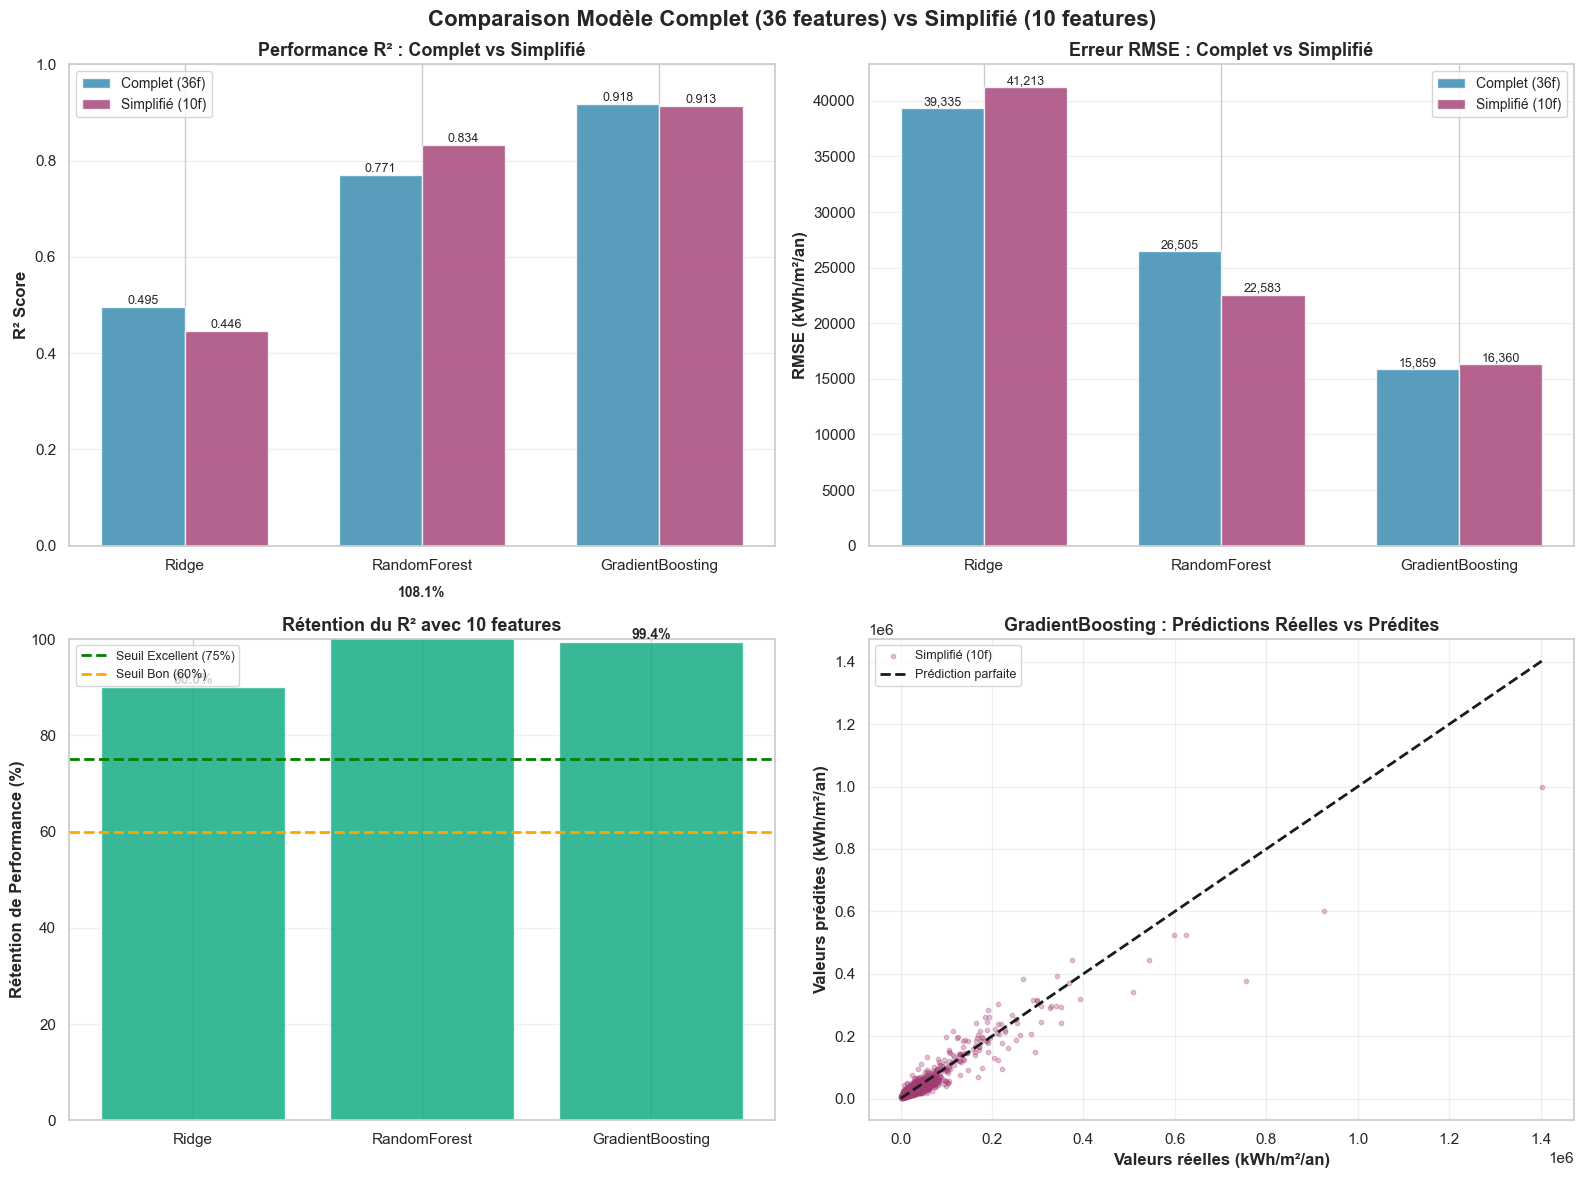


✅ Visualisations générées avec succès


In [83]:
# ========================================
# VISUALISATION DES COMPARAISONS
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparaison Modèle Complet (36 features) vs Simplifié (10 features)', 
             fontsize=16, fontweight='bold')

# 1. Graphique en barres - R² Score
ax1 = axes[0, 0]
x = np.arange(len(df_comparison))
width = 0.35

bars1 = ax1.bar(x - width/2, df_comparison['R²_Complet (36f)'], width, 
                label='Complet (36f)', color='#2E86AB', alpha=0.8)
bars2 = ax1.bar(x + width/2, df_comparison['R²_Simplifié (10f)'], width, 
                label='Simplifié (10f)', color='#A23B72', alpha=0.8)

ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Performance R² : Complet vs Simplifié', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_comparison['Modèle'], fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# Ajouter les valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Graphique en barres - RMSE
ax2 = axes[0, 1]
bars3 = ax2.bar(x - width/2, df_comparison['RMSE_Complet'], width, 
                label='Complet (36f)', color='#2E86AB', alpha=0.8)
bars4 = ax2.bar(x + width/2, df_comparison['RMSE_Simplifié'], width, 
                label='Simplifié (10f)', color='#A23B72', alpha=0.8)

ax2.set_ylabel('RMSE (kWh/m²/an)', fontsize=12, fontweight='bold')
ax2.set_title('Erreur RMSE : Complet vs Simplifié', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(df_comparison['Modèle'], fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Ajouter les valeurs
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=9)
for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# 3. Rétention de performance (%)
ax3 = axes[1, 0]
colors = ['#06A77D' if x >= 75 else '#F77E21' if x >= 60 else '#D62828' 
          for x in df_comparison['Rétention R² (%)']]
bars5 = ax3.bar(df_comparison['Modèle'], df_comparison['Rétention R² (%)'], 
                color=colors, alpha=0.8)

ax3.set_ylabel('Rétention de Performance (%)', fontsize=12, fontweight='bold')
ax3.set_title('Rétention du R² avec 10 features', fontsize=13, fontweight='bold')
ax3.axhline(y=75, color='green', linestyle='--', linewidth=2, label='Seuil Excellent (75%)')
ax3.axhline(y=60, color='orange', linestyle='--', linewidth=2, label='Seuil Bon (60%)')
ax3.legend(fontsize=9)
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 100])

# Ajouter les valeurs
for bar in bars5:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Scatter plot - Prédictions GradientBoosting (meilleur modèle)
ax4 = axes[1, 1]

# Échantillonner pour la visualisation (trop de points sinon)
sample_size = min(5000, len(y_test_user))
sample_indices = np.random.choice(len(y_test_user), size=sample_size, replace=False)
y_test_sample = y_test_user.iloc[sample_indices]
y_pred_user_sample = results_user['GradientBoosting']['y_pred_test'][sample_indices]

# Pour le modèle complet, utiliser les mêmes valeurs réelles (y_test_user) 
# mais avec les prédictions complètes sur tout y_test_reg
# On utilise seulement le modèle user-friendly pour la comparaison visuelle
ax4.scatter(y_test_sample, y_pred_user_sample, alpha=0.3, s=10, 
            label='Simplifié (10f)', color='#A23B72')

# Ligne de référence
min_val = min(y_test_sample.min(), y_pred_user_sample.min())
max_val = max(y_test_sample.max(), y_pred_user_sample.max())
ax4.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Prédiction parfaite')

ax4.set_xlabel('Valeurs réelles (kWh/m²/an)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Valeurs prédites (kWh/m²/an)', fontsize=12, fontweight='bold')
ax4.set_title('GradientBoosting : Prédictions Réelles vs Prédites', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualisations générées avec succès")

## Partie 4 : Modèle de Classification User-Friendly - Prédiction des passoires énergétiques (DPE F et G)

**Utilisation des 10 features user-friendly** pour la classification, identiques à celles utilisées en régression.

### 4.1 Préparation des données pour la classification

In [84]:
# ========================================
# PRÉPARATION DES DONNÉES CLASSIFICATION USER-FRIENDLY
# ========================================

print("\n" + "="*80)
print("PRÉPARATION CLASSIFICATION AVEC 10 FEATURES USER-FRIENDLY")
print("="*80)

# Target : passoire énergétique (DPE F ou G)
y_classification_user = df_work['passoire']

print(f"\n✓ Features utilisées : {len(available_user_features)} variables")
print(f"  • Variables identiques à la régression user-friendly")
print(f"  • Surface, période construction, type bâtiment, etc.")

# Vérifier la distribution de la cible
print(f"\n📊 Distribution de la cible 'passoire' :")
print(f"  • Total observations : {len(y_classification_user):,}")
print(f"  • Passoires (1)      : {y_classification_user.sum():,} ({y_classification_user.mean()*100:.1f}%)")
print(f"  • Non-passoires (0)  : {(~y_classification_user.astype(bool)).sum():,} ({(1-y_classification_user.mean())*100:.1f}%)")

# Division train/test avec stratification (même split que pour la régression)
X_train_clf_user, X_test_clf_user, y_train_clf_user, y_test_clf_user = train_test_split(
    X_user, y_classification_user, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_classification_user
)

print(f"\n{'─'*80}")
print(f"DATASETS CRÉÉS")
print(f"{'─'*80}")
print(f"Entraînement : {X_train_clf_user.shape}")
print(f"Test         : {X_test_clf_user.shape}")

print(f"\nDistribution Train :")
print(f"  • Passoires     : {y_train_clf_user.sum():,} ({y_train_clf_user.mean()*100:.1f}%)")
print(f"  • Non-passoires : {(~y_train_clf_user.astype(bool)).sum():,} ({(1-y_train_clf_user.mean())*100:.1f}%)")

print(f"\nDistribution Test :")
print(f"  • Passoires     : {y_test_clf_user.sum():,} ({y_test_clf_user.mean()*100:.1f}%)")
print(f"  • Non-passoires : {(~y_test_clf_user.astype(bool)).sum():,} ({(1-y_test_clf_user.mean())*100:.1f}%)")

print(f"\n✅ Données prêtes pour la classification")


PRÉPARATION CLASSIFICATION AVEC 10 FEATURES USER-FRIENDLY

✓ Features utilisées : 10 variables
  • Variables identiques à la régression user-friendly
  • Surface, période construction, type bâtiment, etc.

📊 Distribution de la cible 'passoire' :
  • Total observations : 203,792
  • Passoires (1)      : 29,993 (14.7%)
  • Non-passoires (0)  : 173,799 (85.3%)

────────────────────────────────────────────────────────────────────────────────
DATASETS CRÉÉS
────────────────────────────────────────────────────────────────────────────────
Entraînement : (163033, 10)
Test         : (40759, 10)

Distribution Train :
  • Passoires     : 23,994 (14.7%)
  • Non-passoires : 139,039 (85.3%)

Distribution Test :
  • Passoires     : 5,999 (14.7%)
  • Non-passoires : 34,760 (85.3%)

✅ Données prêtes pour la classification


### 4.2 Optimisation des modèles de classification avec GridSearchCV

In [85]:
# ========================================
# DÉFINITION DES MODÈLES CLASSIFICATION USER-FRIENDLY
# ========================================

print("\n" + "="*80)
print("CONFIGURATION DES MODÈLES DE CLASSIFICATION")
print("="*80)

# Définition des modèles et hyperparamètres (simplifiés pour rapidité)
models_classification_user = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'model__C': [0.1, 1.0, 10.0],
            'model__penalty': ['l2'],
            'model__solver': ['lbfgs']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=1),
        'params': {
            'model__n_estimators': [100],
            'model__max_depth': [15, 20],
            'model__min_samples_split': [5],
            'model__min_samples_leaf': [2],
            'model__class_weight': ['balanced']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [50],
            'model__learning_rate': [0.1],
            'model__max_depth': [3, 5],
            'model__min_samples_split': [5]
        }
    }
}

print("\n✓ Modèles configurés :")
for name, config in models_classification_user.items():
    n_combinations = 1
    for param_values in config['params'].values():
        n_combinations *= len(param_values)
    print(f"  • {name:25s} : {n_combinations} combinaisons à tester")


CONFIGURATION DES MODÈLES DE CLASSIFICATION

✓ Modèles configurés :
  • LogisticRegression        : 3 combinaisons à tester
  • RandomForest              : 2 combinaisons à tester
  • GradientBoosting          : 2 combinaisons à tester


In [86]:
# ========================================
# ENTRAÎNEMENT MODÈLES CLASSIFICATION USER-FRIENDLY
# ========================================

import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results_classification_user = {}

for model_name, model_config in models_classification_user.items():
    start_time = time.time()
    
    # Créer le pipeline avec le preprocessor user-friendly
    pipeline = Pipeline([
        ('preprocessor', user_preprocessor),
        ('model', model_config['model'])
    ])
    
    # GridSearchCV avec AUC-ROC comme métrique
    grid_search = GridSearchCV(
        pipeline,
        model_config['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0  # Aucune sortie pendant l'entraînement
    )
    
    # Entraînement silencieux
    grid_search.fit(X_train_clf_user, y_train_clf_user)
    
    # Prédictions
    y_pred_train = grid_search.predict(X_train_clf_user)
    y_pred_test = grid_search.predict(X_test_clf_user)
    y_pred_proba_test = grid_search.predict_proba(X_test_clf_user)[:, 1]
    
    # Métriques
    accuracy = accuracy_score(y_test_clf_user, y_pred_test)
    precision = precision_score(y_test_clf_user, y_pred_test)
    recall = recall_score(y_test_clf_user, y_pred_test)
    f1 = f1_score(y_test_clf_user, y_pred_test)
    roc_auc = roc_auc_score(y_test_clf_user, y_pred_proba_test)
    
    elapsed = time.time() - start_time
    
    # Stocker les résultats
    results_classification_user[model_name] = {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'y_pred_test': y_pred_test,
        'y_pred_proba_test': y_pred_proba_test,
        'training_time': elapsed
    }

# Affichage du résumé final
print("="*80)
print("RÉSUMÉ - MODÈLES CLASSIFICATION (10 FEATURES)")
print("="*80)

results_df_clf_user = pd.DataFrame({
    'Modèle': list(results_classification_user.keys()),
    'Accuracy': [results_classification_user[m]['accuracy'] for m in results_classification_user],
    'Precision': [results_classification_user[m]['precision'] for m in results_classification_user],
    'Recall': [results_classification_user[m]['recall'] for m in results_classification_user],
    'F1-Score': [results_classification_user[m]['f1_score'] for m in results_classification_user],
    'ROC-AUC': [results_classification_user[m]['roc_auc'] for m in results_classification_user],
    'Temps (s)': [results_classification_user[m]['training_time'] for m in results_classification_user]
}).sort_values('ROC-AUC', ascending=False)

print(results_df_clf_user.to_string(index=False))


RÉSUMÉ - MODÈLES CLASSIFICATION (10 FEATURES)
            Modèle  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Temps (s)
      RandomForest  0.856204   0.506607 0.881980  0.643557 0.939127 216.253716
  GradientBoosting  0.896097   0.722840 0.476913  0.574671 0.933026 163.770221
LogisticRegression  0.887951   0.669668 0.471079  0.553087 0.915088  18.600686


In [87]:
# ========================================
# RÉSUMÉ DES RÉSULTATS CLASSIFICATION
# ========================================

print("\n" + "="*80)
print("TABLEAU COMPARATIF DES MODÈLES DE CLASSIFICATION")
print("="*80)

# Créer un DataFrame de comparaison
results_clf_df = pd.DataFrame({
    'Modèle': list(results_classification_user.keys()),
    'Accuracy': [results_classification_user[m]['accuracy'] for m in results_classification_user],
    'Precision': [results_classification_user[m]['precision'] for m in results_classification_user],
    'Recall': [results_classification_user[m]['recall'] for m in results_classification_user],
    'F1-Score': [results_classification_user[m]['f1_score'] for m in results_classification_user],
    'ROC-AUC': [results_classification_user[m]['roc_auc'] for m in results_classification_user],
    'Temps (s)': [results_classification_user[m]['training_time'] for m in results_classification_user]
}).sort_values('ROC-AUC', ascending=False)

print("\n" + results_clf_df.to_string(index=False))

# Identifier le meilleur modèle
best_clf_model = results_clf_df.iloc[0]['Modèle']
best_roc_auc = results_clf_df.iloc[0]['ROC-AUC']

print(f"\n{'='*80}")
print(f"🏆 MEILLEUR MODÈLE : {best_clf_model}")
print(f"{'='*80}")
print(f"  • ROC-AUC  : {best_roc_auc:.4f}")
print(f"  • F1-Score : {results_clf_df.iloc[0]['F1-Score']:.4f}")
print(f"  • Precision: {results_clf_df.iloc[0]['Precision']:.4f}")
print(f"  • Recall   : {results_clf_df.iloc[0]['Recall']:.4f}")


TABLEAU COMPARATIF DES MODÈLES DE CLASSIFICATION

            Modèle  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Temps (s)
      RandomForest  0.856204   0.506607 0.881980  0.643557 0.939127 216.253716
  GradientBoosting  0.896097   0.722840 0.476913  0.574671 0.933026 163.770221
LogisticRegression  0.887951   0.669668 0.471079  0.553087 0.915088  18.600686

🏆 MEILLEUR MODÈLE : RandomForest
  • ROC-AUC  : 0.9391
  • F1-Score : 0.6436
  • Precision: 0.5066
  • Recall   : 0.8820


### 4.3 Visualisations des performances de classification

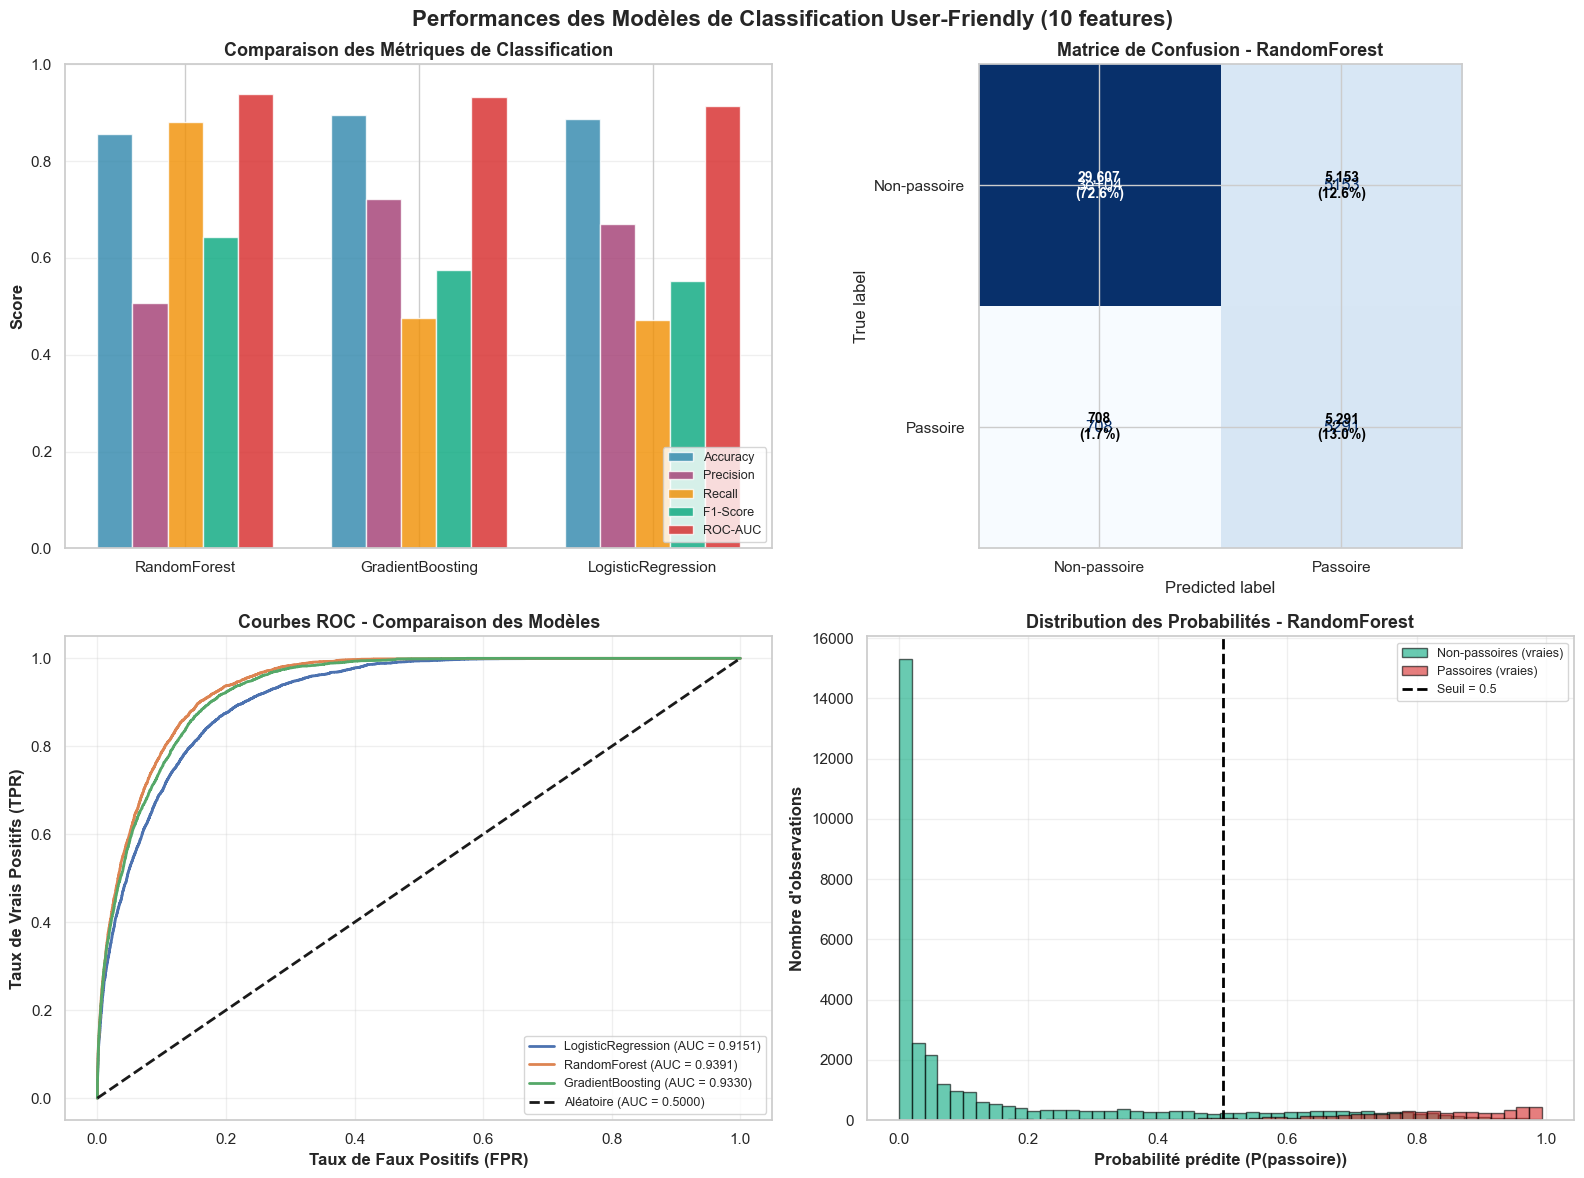


✅ Visualisations générées avec succès


In [88]:
# ========================================
# VISUALISATION DES PERFORMANCES CLASSIFICATION
# ========================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performances des Modèles de Classification User-Friendly (10 features)', 
             fontsize=16, fontweight='bold')

# 1. Comparaison des métriques en barres groupées
ax1 = axes[0, 0]
x = np.arange(len(results_clf_df))
width = 0.15

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors_metrics = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D', '#D62828']

for i, metric in enumerate(metrics):
    offset = width * (i - 2)
    bars = ax1.bar(x + offset, results_clf_df[metric], width, 
                   label=metric, color=colors_metrics[i], alpha=0.8)

ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Comparaison des Métriques de Classification', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results_clf_df['Modèle'], fontsize=11)
ax1.legend(fontsize=9, loc='lower right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# 2. Matrice de confusion du meilleur modèle
ax2 = axes[0, 1]
best_model_name = results_clf_df.iloc[0]['Modèle']
y_pred_best = results_classification_user[best_model_name]['y_pred_test']

cm = confusion_matrix(y_test_clf_user, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-passoire', 'Passoire'])
disp.plot(ax=ax2, cmap='Blues', colorbar=False)
ax2.set_title(f'Matrice de Confusion - {best_model_name}', fontsize=13, fontweight='bold')

# Ajouter des annotations
for i in range(2):
    for j in range(2):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax2.text(j, i, f'{cm[i, j]:,}\n({cm[i, j]/cm.sum()*100:.1f}%)',
                ha='center', va='center', color=text_color, fontsize=10, fontweight='bold')

# 3. Courbes ROC pour les 3 modèles
ax3 = axes[1, 0]

for model_name in results_classification_user.keys():
    y_proba = results_classification_user[model_name]['y_pred_proba_test']
    fpr, tpr, _ = roc_curve(y_test_clf_user, y_proba)
    roc_auc = results_classification_user[model_name]['roc_auc']
    
    ax3.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

ax3.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Aléatoire (AUC = 0.5000)')
ax3.set_xlabel('Taux de Faux Positifs (FPR)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Taux de Vrais Positifs (TPR)', fontsize=12, fontweight='bold')
ax3.set_title('Courbes ROC - Comparaison des Modèles', fontsize=13, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)

# 4. Distribution des probabilités prédites (meilleur modèle)
ax4 = axes[1, 1]
y_proba_best = results_classification_user[best_model_name]['y_pred_proba_test']

# Séparer les probabilités selon la vraie classe
proba_non_passoire = y_proba_best[y_test_clf_user == 0]
proba_passoire = y_proba_best[y_test_clf_user == 1]

ax4.hist(proba_non_passoire, bins=50, alpha=0.6, label='Non-passoires (vraies)', 
         color='#06A77D', edgecolor='black')
ax4.hist(proba_passoire, bins=50, alpha=0.6, label='Passoires (vraies)', 
         color='#D62828', edgecolor='black')

ax4.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Seuil = 0.5')
ax4.set_xlabel('Probabilité prédite (P(passoire))', fontsize=12, fontweight='bold')
ax4.set_ylabel('Nombre d\'observations', fontsize=12, fontweight='bold')
ax4.set_title(f'Distribution des Probabilités - {best_model_name}', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualisations générées avec succès")

### 4.4 Importance des features pour la classification


IMPORTANCE DES FEATURES POUR LA CLASSIFICATION


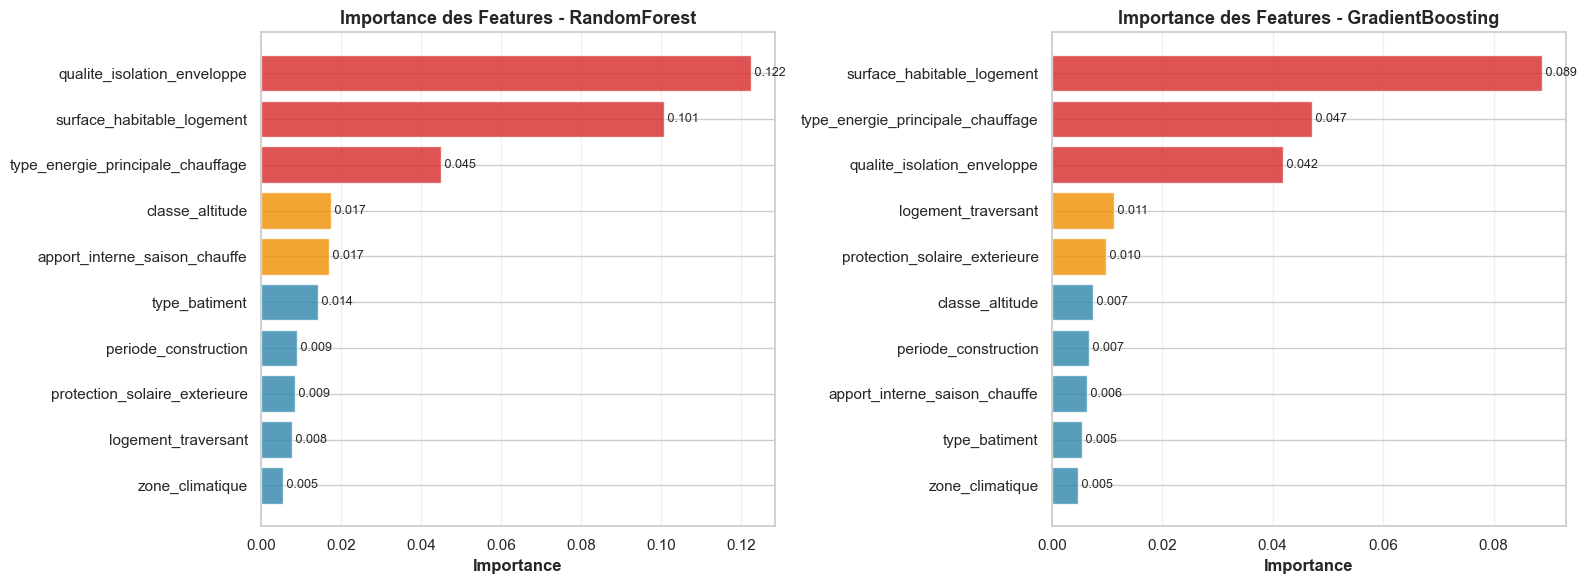


────────────────────────────────────────────────────────────────────────────────
TOP 5 FEATURES - RandomForest
────────────────────────────────────────────────────────────────────────────────
  qualite_isolation_enveloppe              : 0.1224
  surface_habitable_logement               : 0.1007
  type_energie_principale_chauffage        : 0.0451
  classe_altitude                          : 0.0175
  apport_interne_saison_chauffe            : 0.0171

────────────────────────────────────────────────────────────────────────────────
TOP 5 FEATURES - GradientBoosting
────────────────────────────────────────────────────────────────────────────────
  surface_habitable_logement               : 0.0887
  type_energie_principale_chauffage        : 0.0471
  qualite_isolation_enveloppe              : 0.0418
  logement_traversant                      : 0.0113
  protection_solaire_exterieure            : 0.0099

💡 CONCLUSION : Les mêmes features importantes en régression
   sont aussi importantes pou

In [89]:
# ========================================
# IMPORTANCE DES FEATURES (CLASSIFICATION)
# ========================================

print("\n" + "="*80)
print("IMPORTANCE DES FEATURES POUR LA CLASSIFICATION")
print("="*80)

# Analyser pour RandomForest et GradientBoosting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, model_name in enumerate(['RandomForest', 'GradientBoosting']):
    if model_name in results_classification_user:
        ax = axes[idx]
        
        # Récupérer le modèle entraîné
        best_model = results_classification_user[model_name]['best_model']
        
        # Extraire le modèle de classification du pipeline
        clf_model = best_model.named_steps['model']
        
        # Obtenir les importances
        importances = clf_model.feature_importances_
        
        # Obtenir les noms des features après preprocessing
        # Pour simplifier, on utilise les features d'origine
        feature_names = available_user_features
        
        # Créer un DataFrame
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances[:len(feature_names)]
        }).sort_values('Importance', ascending=False)
        
        # Graphique
        colors = ['#D62828' if i < 3 else '#F18F01' if i < 5 else '#2E86AB' 
                  for i in range(len(importance_df))]
        
        ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors, alpha=0.8)
        ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
        ax.set_title(f'Importance des Features - {model_name}', fontsize=13, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
        
        # Ajouter les valeurs
        for i, (feat, imp) in enumerate(zip(importance_df['Feature'], importance_df['Importance'])):
            ax.text(imp, i, f' {imp:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Afficher le top 5 pour chaque modèle
for model_name in ['RandomForest', 'GradientBoosting']:
    if model_name in results_classification_user:
        print(f"\n{'─'*80}")
        print(f"TOP 5 FEATURES - {model_name}")
        print(f"{'─'*80}")
        
        best_model = results_classification_user[model_name]['best_model']
        clf_model = best_model.named_steps['model']
        importances = clf_model.feature_importances_
        
        importance_df = pd.DataFrame({
            'Feature': available_user_features,
            'Importance': importances[:len(available_user_features)]
        }).sort_values('Importance', ascending=False)
        
        for i, row in importance_df.head(5).iterrows():
            print(f"  {row['Feature']:40s} : {row['Importance']:.4f}")

print(f"\n{'='*80}")
print("💡 CONCLUSION : Les mêmes features importantes en régression")
print("   sont aussi importantes pour la classification des passoires.")
print("="*80)

### 4.5 Synthèse finale : Modèles User-Friendly pour la Webapp

In [90]:
# ========================================
# SYNTHÈSE FINALE : MODÈLES POUR LA WEBAPP
# ========================================

print("\n" + "="*80)
print("RÉCAPITULATIF COMPLET - MODÈLES USER-FRIENDLY (10 FEATURES)")
print("="*80)

print(f"\n📋 FEATURES UTILISÉES ({len(available_user_features)}) :")
print("─"*80)
for i, feat in enumerate(available_user_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\n\n{'='*80}")
print("RÉGRESSION : Prédiction de la consommation énergétique")
print("="*80)

# Meilleur modèle de régression
best_reg_model = max(results_user.keys(), key=lambda k: results_user[k]['r2_test'])
best_reg_r2 = results_user[best_reg_model]['r2_test']
best_reg_rmse = results_user[best_reg_model]['rmse_test']

print(f"\n🏆 Meilleur modèle : {best_reg_model}")
print(f"   • R² Score         : {best_reg_r2:.4f} ({best_reg_r2*100:.1f}% de variance expliquée)")
print(f"   • RMSE             : {best_reg_rmse:,.2f} kWh/m²/an")
print(f"   • MAE              : {results_user[best_reg_model]['mae_test']:,.2f} kWh/m²/an")

# Comparaison avec modèle complet
full_reg_r2 = results_regression[best_reg_model]['r2']
retention = (best_reg_r2 / full_reg_r2) * 100
print(f"\n   ✓ Rétention vs modèle complet (36f) : {retention:.1f}%")

print(f"\n\n{'='*80}")
print("CLASSIFICATION : Prédiction des passoires énergétiques (DPE F/G)")
print("="*80)

# Meilleur modèle de classification
best_clf_model = max(results_classification_user.keys(), 
                     key=lambda k: results_classification_user[k]['roc_auc'])
best_clf_auc = results_classification_user[best_clf_model]['roc_auc']
best_clf_f1 = results_classification_user[best_clf_model]['f1_score']

print(f"\n🏆 Meilleur modèle : {best_clf_model}")
print(f"   • ROC-AUC          : {best_clf_auc:.4f}")
print(f"   • F1-Score         : {best_clf_f1:.4f}")
print(f"   • Accuracy         : {results_classification_user[best_clf_model]['accuracy']:.4f}")
print(f"   • Precision        : {results_classification_user[best_clf_model]['precision']:.4f}")
print(f"   • Recall           : {results_classification_user[best_clf_model]['recall']:.4f}")

print(f"\n\n{'='*80}")
print("RECOMMANDATIONS POUR LE DÉPLOIEMENT WEBAPP")
print("="*80)

print(f"\n✅ MODÈLES VALIDÉS POUR PRODUCTION")
print(f"\n1️⃣  RÉGRESSION (prédiction consommation) :")
print(f"    → Modèle : {best_reg_model}")
print(f"    → Performance : R² = {best_reg_r2:.4f}, RMSE = {best_reg_rmse:,.0f} kWh/m²/an")
print(f"    → Usage : Estimer la consommation énergétique annuelle")

print(f"\n2️⃣  CLASSIFICATION (détection passoires) :")
print(f"    → Modèle : {best_clf_model}")
print(f"    → Performance : ROC-AUC = {best_clf_auc:.4f}, F1 = {best_clf_f1:.4f}")
print(f"    → Usage : Identifier si le logement est une passoire (DPE F ou G)")

print(f"\n📝 EXPÉRIENCE UTILISATEUR WEBAPP :")
print(f"    • Nombre de questions    : 5-7 (3 auto-calculées)")
print(f"    • Temps de saisie estimé : ~2 minutes")
print(f"    • Variables auto-dérivées :")
print(f"      - zone_climatique        → depuis code postal")
print(f"      - classe_altitude        → depuis code postal")
print(f"      - apport_interne...      → surface × 15")

print(f"\n💾 PROCHAINES ÉTAPES :")
print(f"    1. Sauvegarder les modèles (joblib.dump)")
print(f"    2. Créer les fonctions de preprocessing")
print(f"    3. Développer l'API Flask/FastAPI")
print(f"    4. Intégrer dans l'interface web")

print(f"\n{'='*80}")
print("✅ ANALYSE TERMINÉE - MODÈLES PRÊTS POUR LA WEBAPP")
print("="*80)


RÉCAPITULATIF COMPLET - MODÈLES USER-FRIENDLY (10 FEATURES)

📋 FEATURES UTILISÉES (10) :
────────────────────────────────────────────────────────────────────────────────
   1. surface_habitable_logement
   2. periode_construction
   3. type_batiment
   4. qualite_isolation_enveloppe
   5. type_energie_principale_chauffage
   6. logement_traversant
   7. protection_solaire_exterieure
   8. zone_climatique
   9. classe_altitude
  10. apport_interne_saison_chauffe


RÉGRESSION : Prédiction de la consommation énergétique

🏆 Meilleur modèle : GradientBoosting
   • R² Score         : 0.9127 (91.3% de variance expliquée)
   • RMSE             : 16,359.65 kWh/m²/an
   • MAE              : 5,075.47 kWh/m²/an

   ✓ Rétention vs modèle complet (36f) : 99.4%


CLASSIFICATION : Prédiction des passoires énergétiques (DPE F/G)

🏆 Meilleur modèle : RandomForest
   • ROC-AUC          : 0.9391
   • F1-Score         : 0.6436
   • Accuracy         : 0.8562
   • Precision        : 0.5066
   • Recall      

## Partie 5 : Sauvegarde des Modèles pour la Webapp

Les modèles user-friendly (10 features) ont été validés et sont prêts pour le déploiement.
Nous allons maintenant les sauvegarder pour utilisation dans la webapp.

In [91]:
# ========================================
# SAUVEGARDE DES MODÈLES POUR LA WEBAPP
# ========================================

import joblib
from datetime import datetime

# Créer un timestamp pour versionner les modèles
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("\n" + "="*80)
print("SAUVEGARDE DES MODÈLES USER-FRIENDLY")
print("="*80)

# Créer le dossier de sauvegarde
import os
models_dir = "models_pkl"
os.makedirs(models_dir, exist_ok=True)

print(f"\n📁 Dossier de sauvegarde : {models_dir}/")

# 1. Sauvegarder le meilleur modèle de RÉGRESSION
best_reg_model_name = max(results_user.keys(), key=lambda k: results_user[k]['r2_test'])
best_reg_model = results_user[best_reg_model_name]['best_model']
best_reg_r2 = results_user[best_reg_model_name]['r2_test']
best_reg_rmse = results_user[best_reg_model_name]['rmse_test']

reg_filename = f"{models_dir}/regression_{best_reg_model_name.lower()}_{timestamp}.pkl"
joblib.dump(best_reg_model, reg_filename)

print(f"\n✅ RÉGRESSION sauvegardée :")
print(f"   • Modèle   : {best_reg_model_name}")
print(f"   • R²       : {best_reg_r2:.4f}")
print(f"   • RMSE     : {best_reg_rmse:,.2f} kWh/m²/an")
print(f"   • Fichier  : {reg_filename}")

# 2. Sauvegarder le meilleur modèle de CLASSIFICATION
best_clf_model_name = max(results_classification_user.keys(), 
                          key=lambda k: results_classification_user[k]['roc_auc'])
best_clf_model = results_classification_user[best_clf_model_name]['best_model']
best_clf_auc = results_classification_user[best_clf_model_name]['roc_auc']
best_clf_f1 = results_classification_user[best_clf_model_name]['f1_score']

clf_filename = f"{models_dir}/classification_{best_clf_model_name.lower()}_{timestamp}.pkl"
joblib.dump(best_clf_model, clf_filename)

print(f"\n✅ CLASSIFICATION sauvegardée :")
print(f"   • Modèle   : {best_clf_model_name}")
print(f"   • ROC-AUC  : {best_clf_auc:.4f}")
print(f"   • F1-Score : {best_clf_f1:.4f}")
print(f"   • Fichier  : {clf_filename}")

# 3. Sauvegarder les métadonnées (features utilisées, etc.)
metadata = {
    'timestamp': timestamp,
    'features': available_user_features,
    'n_features': len(available_user_features),
    'regression': {
        'model_name': best_reg_model_name,
        'r2_score': float(best_reg_r2),
        'rmse': float(best_reg_rmse),
        'mae': float(results_user[best_reg_model_name]['mae_test']),
        'target': 'conso_5_usages_ep'
    },
    'classification': {
        'model_name': best_clf_model_name,
        'roc_auc': float(best_clf_auc),
        'f1_score': float(best_clf_f1),
        'accuracy': float(results_classification_user[best_clf_model_name]['accuracy']),
        'precision': float(results_classification_user[best_clf_model_name]['precision']),
        'recall': float(results_classification_user[best_clf_model_name]['recall']),
        'target': 'passoire'
    },
    'preprocessing': {
        'numeric_features': user_numeric,
        'categorical_features': user_categorical
    }
}

metadata_filename = f"{models_dir}/metadata_{timestamp}.pkl"
joblib.dump(metadata, metadata_filename)

print(f"\n✅ MÉTADONNÉES sauvegardées :")
print(f"   • Fichier : {metadata_filename}")
print(f"   • Contenu : Features, performances, configuration")

print(f"\n{'='*80}")
print(f"💾 SAUVEGARDE TERMINÉE")
print(f"{'='*80}")
print(f"\n📦 Fichiers créés :")
print(f"   1. {reg_filename}")
print(f"   2. {clf_filename}")
print(f"   3. {metadata_filename}")

print(f"\n💡 Exemple d'intégration :")
print(f"""
import joblib

# Charger les modèles
model_reg = joblib.load('{reg_filename}')
model_clf = joblib.load('{clf_filename}')
metadata = joblib.load('{metadata_filename}')

# Faire une prédiction
# prediction_conso = model_reg.predict(X_new)
# prediction_passoire = model_clf.predict(X_new)
""")


SAUVEGARDE DES MODÈLES USER-FRIENDLY

📁 Dossier de sauvegarde : models_pkl/

✅ RÉGRESSION sauvegardée :
   • Modèle   : GradientBoosting
   • R²       : 0.9127
   • RMSE     : 16,359.65 kWh/m²/an
   • Fichier  : models_pkl/regression_gradientboosting_20251031_011714.pkl

✅ CLASSIFICATION sauvegardée :
   • Modèle   : RandomForest
   • ROC-AUC  : 0.9391
   • F1-Score : 0.6436
   • Fichier  : models_pkl/classification_randomforest_20251031_011714.pkl

✅ MÉTADONNÉES sauvegardées :
   • Fichier : models_pkl/metadata_20251031_011714.pkl
   • Contenu : Features, performances, configuration

💾 SAUVEGARDE TERMINÉE

📦 Fichiers créés :
   1. models_pkl/regression_gradientboosting_20251031_011714.pkl
   2. models_pkl/classification_randomforest_20251031_011714.pkl
   3. models_pkl/metadata_20251031_011714.pkl

💡 Exemple d'intégration :

import joblib

# Charger les modèles
model_reg = joblib.load('models_pkl/regression_gradientboosting_20251031_011714.pkl')
model_clf = joblib.load('models_pkl/cl

### Récapitulatif Final

In [94]:
# ========================================
# RÉCAPITULATIF FINAL DU PROJET
# ========================================

print("\n" + "="*80)
print("RÉSUMÉ COMPLET DU PROJET - PRÉDICTION DPE HAUTE-SAVOIE")
print("="*80)

print(f"""
📊 DATASET
──────────────────────────────────────────────────────────────────────────────
  • Source            : logements_74.csv
  • Observations      : {len(df_work):,} logements en Haute-Savoie
  • Variables totales : 236 colonnes initiales
  • Features finales  : {len(available_user_features)} variables user-friendly

📋 FEATURES SÉLECTIONNÉES (10 variables)
──────────────────────────────────────────────────────────────────────────────
""")

for i, feat in enumerate(available_user_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"""

🎯 MODÈLES DÉVELOPPÉS
──────────────────────────────────────────────────────────────────────────────

1️⃣  RÉGRESSION : Prédiction de la consommation énergétique
    Target           : conso_5_usages_ep (kWh/m²/an)
    Meilleur modèle  : {best_reg_model_name}
    Performance      : R² = {best_reg_r2:.4f} (variance expliquée : {best_reg_r2*100:.1f}%)
                       RMSE = {best_reg_rmse:,.2f} kWh/m²/an
                       MAE = {results_user[best_reg_model_name]['mae_test']:,.2f} kWh/m²/an
    
    ✓ Rétention vs modèle complet (36f) : {(best_reg_r2 / results_regression[best_reg_model_name]['r2'])*100:.1f}%

2️⃣  CLASSIFICATION : Détection des passoires énergétiques (DPE F/G)
    Target           : passoire (0=Non, 1=Oui)
    Meilleur modèle  : {best_clf_model_name}
    Performance      : ROC-AUC = {best_clf_auc:.4f}
                       F1-Score = {best_clf_f1:.4f}
                       Accuracy = {results_classification_user[best_clf_model_name]['accuracy']:.4f}
                       Precision = {results_classification_user[best_clf_model_name]['precision']:.4f}
                       Recall = {results_classification_user[best_clf_model_name]['recall']:.4f}

💾 SAUVEGARDE
──────────────────────────────────────────────────────────────────────────────
  • Dossier         : {models_dir}
  • Modèle régression    : ✅ Sauvegardé
  • Modèle classification : ✅ Sauvegardé
  • Métadonnées     : ✅ Sauvegardées

""")

print("="*80)
print("✅ PROJET TERMINÉ")
print("="*80)



RÉSUMÉ COMPLET DU PROJET - PRÉDICTION DPE HAUTE-SAVOIE

📊 DATASET
──────────────────────────────────────────────────────────────────────────────
  • Source            : logements_74.csv
  • Observations      : 203,792 logements en Haute-Savoie
  • Variables totales : 236 colonnes initiales
  • Features finales  : 10 variables user-friendly

📋 FEATURES SÉLECTIONNÉES (10 variables)
──────────────────────────────────────────────────────────────────────────────

   1. surface_habitable_logement
   2. periode_construction
   3. type_batiment
   4. qualite_isolation_enveloppe
   5. type_energie_principale_chauffage
   6. logement_traversant
   7. protection_solaire_exterieure
   8. zone_climatique
   9. classe_altitude
  10. apport_interne_saison_chauffe


🎯 MODÈLES DÉVELOPPÉS
──────────────────────────────────────────────────────────────────────────────

1️⃣  RÉGRESSION : Prédiction de la consommation énergétique
    Target           : conso_5_usages_ep (kWh/m²/an)
    Meilleur modèle  : G